In [1]:
import awkward
import xgboost
import numpy as np
import os
import json
import awkward as ak
import coffea.util as util
#%pip install sklearn
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

import hist

In [2]:
xgboost

<module 'xgboost' from '/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/__init__.py'>

In [3]:
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
    
    

In [4]:
# Read files and normalise the weights

In [5]:
%ll input/

total 98
-rw-r--r--  1 bevila_t   363 Jun 19 14:17 background_GJets_HT-200To400_M125.coffea
-rw-r--r--  1 bevila_t   364 Jun 19 14:17 background_GJets_HT-400To600_M125.coffea
-rw-r--r--  1 bevila_t   366 Jun 19 14:17 background_GJets_HT40To200_M125.coffea
-rw-r--r--  1 bevila_t   304 Jun 28 16:15 background_QCD_M125.coffea
-rw-r--r--  1 bevila_t  9746 Jun 19 14:17 backgrounds_DiphotonBox_high_mass_M125.coffea
-rw-r--r--  1 bevila_t  8416 Jun 19 14:17 backgrounds_DiphotonBox_low_mass_M125.coffea
-rw-r--r--  1 bevila_t 10056 Jun 12 12:28 ch_signal.coffea
-rw-r--r--  1 bevila_t   324 Jun 20 22:36 data.coffea
drwxr-xr-x  2 bevila_t    23 Jun 29 14:01 master-dev/
drwxr-xr-x 10 bevila_t    10 Jun 28 18:19 merged_backgrounds/
drwxr-xr-x  2 bevila_t     7 Jun 21 10:59 merged_data/
drwxr-xr-x  7 bevila_t     7 Jun 19 14:04 merged_signals/
drwxr-xr-x  2 bevila_t     8 Jun 21 10:59 _old_data/
drwxr-xr-x  4 bevila_t     6 Jun 28 18:19 _old_QCD/
-rw-r--r--  1 bevila_t 34397 Jun 12 12:40 signals.cof

In [6]:
proc_dict = {
    "cH_4FS_FXFX_M125_2017": {
        "file": "input/merged_signals/cH_4FS_FXFX_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/ch_signal.coffea",
        "label": 1.,
        "proc_id": 1,
    },
    "ggh_M125_2017": {
        "file": "input/merged_signals/ggh_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/ggh_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 2,
    },
    "tth_M125_2017": {
        "file": "input/merged_signals/tth_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/tth_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 3,
    },
    "vbf_M125_2017": {
        "file": "input/merged_signals/vbf_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/vbf_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 4,
    },
    "vh_M125_2017": {
        "file": "input/merged_signals/vh_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/vh_M125_2017_UNTAGGED_merged.parquet",
        "type": "signal",
        "coffea": "input/signals.coffea",
        # "coffea": "input/master-dev/signals.coffea",
        "label": 1.,
        "proc_id": 5,
    },
    "DiphotonBox_low_mass_M125_2017": {
        "file": "input/merged_backgrounds/DiphotonBox_low_mass_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DiphotonBox_low_mass_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/backgrounds_DiphotonBox_low_mass_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -1,
    },
    "DiphotonBox_high_mass_M125_2017": {
        "file": "input/merged_backgrounds/DiphotonBox_high_mass_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DiphotonBox_high_mass_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/backgrounds_DiphotonBox_high_mass_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -1,
    },
    "GJets_HT-40To100_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-40To100_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-40To100_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT40To200_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-100To200_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-100To200_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-100To200_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT40To200_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-200To400_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-200To400_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-200To400_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT-200To400_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "GJets_HT-400To600_M125_2017": {
        "file": "input/merged_backgrounds/GJets_HT-400To600_M125_2017/NOMINAL/UNTAGGED_merged.parquet",
        # "file": "input/master-dev/GJets_HT-400To600_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/background_GJets_HT-400To600_M125.coffea",
        # "coffea": "input/master-dev/backgrounds.coffea",
        "label": 0.,
        "proc_id": -2,
    },
    "QCD_M125_2017": {
        "file": "input/merged_backgrounds/QCD_M125_2017_syst_2/NOMINAL/UNTAGGED_merged.parquet",
        #"file": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master/higgs-dna-tiziano-bevilacqua/scripts/out_dir_eta_290623/merged/QCD_M125_2017/nominal/UNTAGGED_merged.parquet",
        #"file": "input/master-dev/QCD_M125_2017_UNTAGGED_merged.parquet",
        "type": "background",
        "coffea": "input/merged_backgrounds/QCD_M125_2017_syst_2/background_QCD_M125.coffea",
        #"coffea": "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev-master/higgs-dna-tiziano-bevilacqua/scripts/out_dir_eta_290623/backgrounds.coffea",
        # "coffea": "input/master-dev/QCD_M125_2017_backgrounds.coffea",
        "label": 0.,
        "proc_id": -3,
    },
    #"Data_2017": {
    #    "file": "input/master-dev/allData_UNTAGGED_merged.parquet",
    #    "type": "data",
    #    # "coffea": "input/data.coffea",
    #    "coffea": "input/master-dev/data.coffea",
    #    "label": -1.,
    #    "proc_id": 0,
    #},
    "DoubleEG_B_2017": {
        "file": "input/merged_data/DoubleEG_B_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_B_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_C_2017": {
        "file": "input/merged_data/DoubleEG_C_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_C_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_D_2017": {
        "file": "input/merged_data/DoubleEG_D_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_D_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_E_2017": {
        "file": "input/merged_data/DoubleEG_E_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_E_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
    "DoubleEG_F_2017": {
        "file": "input/merged_data/DoubleEG_F_2017_UNTAGGED_merged.parquet",
        # "file": "input/master-dev/DoubleEG_F_2017_UNTAGGED_merged.parquet",
        "type": "data",
        # "coffea": "input/data.coffea",
        "coffea": "input/master-dev/data.coffea",
        "label": -1.,
        "proc_id": 0,
    },
}

In [7]:
# concatenate the MC and Data events (separately) and add normalisation

In [8]:
with open(
        "/work/bevila_t/HpC_Analysis/HiggsDNA/coffea/myfork/dev/higgs-dna-tiziano-bevilacqua/higgs_dna/metaconditions/cross_sections.json", "r"
    ) as pf:
        XSs = json.load(pf)

In [9]:
sig_coffea = util.load("input/master-dev/signals.coffea")
bkg_coffea = util.load("input/master-dev/backgrounds.coffea")
data_coffea = util.load("input/master-dev/data.coffea")
qcd_coffea = util.load("input/merged_backgrounds/QCD_M125_2017_syst_2/background_QCD_M125.coffea")


In [10]:
bkg_coffea

{'histos': {},
 'weight_sum': {'ch': 0.0,
  'ggh': 0.0,
  'tth': 0.0,
  'vbf': 0.0,
  'vh': 0.0,
  'nr_gg_low': 4989206.0,
  'nr_gg_high': 29917067.0,
  'gjets': 111623077.0,
  'dy': 0.0,
  'qcd': 0.0,
  'data': 0.0},
 'norm_1fb': {'nr_gg_low': 30229300.0,
  'nr_gg_high': 49964800.0,
  'gjets': 14696974600.0},
 'sel_events': {'nominal': {'nr_gg_low': 1915.0,
   'nr_gg_high': 3071277.0,
   'gjets': 165292.0},
  'FNUF_up': {'nr_gg_low': 1924.0, 'nr_gg_high': 3083360.0, 'gjets': 165995.0},
  'FNUF_down': {'nr_gg_low': 1897.0,
   'nr_gg_high': 3059250.0,
   'gjets': 164611.0},
  'ShowerShape_up': {'nr_gg_low': 1911.0,
   'nr_gg_high': 3069132.0,
   'gjets': 165132.0},
  'ShowerShape_down': {'nr_gg_low': 1915.0,
   'nr_gg_high': 3073659.0,
   'gjets': 165421.0}},
 'tot_events': 146541462.0}

In [11]:
util.load("input/data.coffea")

{'histos': {},
 'weight_sum': {'ch': 0.0,
  'ggh': 0.0,
  'tth': 0.0,
  'vbf': 0.0,
  'vh': 0.0,
  'nr_gg_low': 0.0,
  'nr_gg_high': 0.0,
  'gjets': 0.0,
  'dy': 0.0,
  'qcd': 0.0,
  'data': 265859299.0},
 'norm_1fb': {'data': 5315},
 'sel_events': {'nominal': {'data': 2228246.0}},
 'tot_events': 265859299.0}

In [12]:
sig_events = []
bkg_events = []
data_events = []

# columns = ['weight', 'centralObjectWeight', 'bdt_score', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'n_jets', 'lead_jet_pt', 'lead_jet_eta', 'lead_jet_phi', 'lead_jet_mass', 'lead_jet_PN_CvL', 'lead_jet_PN_CvB', 'lead_jet_PN_B', 'lead_jet_btagDeepFlav_B', 'lead_jet_btagDeepFlav_CvB', 'lead_jet_btagDeepFlav_CvL', 'lead_jet_btagDeepFlav_QG', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ_1', 'dZ_2', 'dZ_3']
columns = ['weight', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ_1', 'dZ_2', 'dZ_3']
               
for i, dataset in enumerate(proc_dict):
    meta = util.load(proc_dict[dataset]["coffea"])
    if dataset == "QCD_M125_2017":
        print(dataset, ":)")
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] / meta["weight_sum"][XSs[dataset]["name"]]  * 1000
        qcd_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
        qcd_events["weight"] = qcd_events["weight"] * norm
        qcd_events["proc_id"] = ak.ones_like(qcd_events["weight"]) * proc_dict[dataset]["proc_id"]
        continue
    print(dataset)
    if proc_dict[dataset]["type"] == "signal":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] / meta["weight_sum"][XSs[dataset]["name"]] * 1000
        proc_dict[dataset]["norm"] = norm
        if len(sig_events) == 0:
            sig_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            sig_events["weight"] = sig_events["weight"] * norm
            sig_events["proc_id"] = ak.ones_like(sig_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            sig_events = ak.concatenate([sig_events, tmp_])
    
    elif proc_dict[dataset]["type"] == "background":
        norm = XSs[dataset]["xs"] * XSs[dataset]["bf"] * XSs["lumi"]["2017"] / meta["weight_sum"][XSs[dataset]["name"]]  * 1000
        proc_dict[dataset]["norm"] = norm
        if len(bkg_events) == 0:
            bkg_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            bkg_events["weight"] = bkg_events["weight"] * norm
            bkg_events["proc_id"] = ak.ones_like(bkg_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["weight"] = tmp_["weight"] * norm
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            bkg_events = ak.concatenate([bkg_events, tmp_])
    
    elif proc_dict[dataset]["type"] == "data":
        if len(data_events) == 0:
            data_events = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            data_events["proc_id"] = ak.ones_like(data_events["weight"]) * proc_dict[dataset]["proc_id"]
        else:
            tmp_ = ak.from_parquet(proc_dict[dataset]["file"], columns=columns)
            tmp_["proc_id"] = ak.ones_like(tmp_["weight"]) * proc_dict[dataset]["proc_id"]
            data_events = ak.concatenate([data_events, tmp_])

sig_events["label"] = ak.ones_like(sig_events["weight"])
bkg_events["label"] = ak.zeros_like(bkg_events["weight"])
data_events["label"] = ak.ones_like(data_events["weight"]) * -1.

cH_4FS_FXFX_M125_2017
ggh_M125_2017
tth_M125_2017
vbf_M125_2017
vh_M125_2017
DiphotonBox_low_mass_M125_2017
DiphotonBox_high_mass_M125_2017
GJets_HT-40To100_M125_2017
GJets_HT-100To200_M125_2017
GJets_HT-200To400_M125_2017
GJets_HT-400To600_M125_2017
QCD_M125_2017 :)
DoubleEG_B_2017
DoubleEG_C_2017
DoubleEG_D_2017
DoubleEG_E_2017
DoubleEG_F_2017


In [13]:
# read old qcd from samuel may's higgsdna
events = []
events = awkward.from_parquet("test_Data_2017_photon_cleaning/merged_nominal.parquet") 
events = awkward.values_astype(events, np.float64)
data   = events[events.process_id==0]
events = events[events.process_id>0]

qcd = events[(events.process_id == 7)]# & (abs(events.LeadPhoton_eta) <= 2.3) & (abs(events.SubleadPhoton_eta) <= 2.3)]
norm = ak.sum(qcd_events.weight) / ak.sum(qcd["weight_central"])
qcd["weight"] = qcd["weight_central"] * norm
qcd["square_weight"] = qcd["weight"] ** 2
qcd["CMS_hgg_mass"] = qcd["Diphoton_mass"]
qcd["pt"] = qcd["Diphoton_pt"]
qcd["eta"] = qcd["Diphoton_eta"]
qcd["phi"] = qcd["Diphoton_phi"]
qcd["dZ"] = ak.zeros_like(qcd["Diphoton_pt"])
qcd = qcd[columns]
qcd["label"] = ak.zeros_like(qcd["weight"])
qcd["proc_id"] = ak.ones_like(qcd["weight"]) * proc_dict["QCD_M125_2017"]["proc_id"]
print(qcd.fields)
bkg_events = ak.concatenate([bkg_events, qcd])

['weight', 'dZ', 'CMS_hgg_mass', 'event', 'pt', 'eta', 'phi', 'LeadPhoton_pt_mgg', 'LeadPhoton_eta', 'LeadPhoton_phi', 'LeadPhoton_mvaID', 'SubleadPhoton_pt_mgg', 'SubleadPhoton_eta', 'SubleadPhoton_phi', 'SubleadPhoton_mvaID', 'Diphoton_cos_dPhi', 'sigmaMrv', 'sigmaMwv', 'PV_score', 'PV_chi2', 'nPV', 'dZ_1', 'dZ_2', 'dZ_3', 'label', 'proc_id']


In [14]:
MC_events = ak.concatenate([sig_events, bkg_events])

# add VtxProbability 
MC_events["vtxProb"] = 2 * MC_events["sigmaMrv"] / (MC_events["sigmaMrv"] + MC_events["sigmaMwv"])
data_events["vtxProb"] = 2 * data_events["sigmaMrv"] / (data_events["sigmaMrv"] + data_events["sigmaMwv"])
MC_events = ak.values_astype(MC_events, np.float64)
data_events = ak.values_astype(data_events, np.float64)
# MC_events.fields

In [15]:
qcd.dZ_2

<Array [7.63, 1.37, 0.0223, ... 5.65, 6.15] type='2333 * float64'>

In [16]:
MC_events.dZ_2

<Array [3.74, 5.57, 4.73, ... 1.21, 5.65, 6.15] type='9674847 * ?float64'>

In [17]:
data_coffea

{'histos': {},
 'weight_sum': {'ch': 0.0,
  'ggh': 0.0,
  'tth': 0.0,
  'vbf': 0.0,
  'vh': 0.0,
  'nr_gg_low': 0.0,
  'nr_gg_high': 0.0,
  'gjets': 0.0,
  'dy': 0.0,
  'qcd': 0.0,
  'data': 265859299.0},
 'norm_1fb': {'data': 5315},
 'sel_events': {'nominal': {'data': 2904109.0}},
 'tot_events': 265859299.0}

In [18]:
bkg_events.weight 

<Array [0.336, 0.336, 0.336, ... 598, 455, 498] type='3002648 * ?float64'>

In [19]:
ak.sum(sig_events.weight[sig_events.proc_id==1])

3.872329277786899

In [20]:
output_dir="test_training" 
config="diphoton_bdt_config.json"

with open(config, "r") as f_in:
    bdt_config = json.load(f_in)

## Anchor by diphoton_eta
eta_fields = [x for x in bdt_config["features"] if "eta" in x]
#for field in bdt_config["features"]:
#    if "dZ" in field:
#        events[field] = events[field] * np.sign(events[field])
for field in eta_fields:
    MC_events[field] = MC_events[field] * np.sign(MC_events.eta)

print("[HiggsDNABonusTool] Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.")

print("[HiggsDNABonusTool] Out of %d total events, found %d signal and %d background events." % (len(MC_events), len(sig_events), len(bkg_events)))

# Add test/train/val split     
split = np.random.randint(3, size = len(MC_events))
MC_events["train_split"] = awkward.from_numpy(split) # 0 = train, 1 = test, 2 = validation

#events = awkward.nan_to_num(events, nan=-999., posinf=-999., neginf=-999.)
print(len(MC_events[MC_events["train_split"] == 0]), len(MC_events[MC_events["train_split"] == 1]), len(MC_events[MC_events["train_split"] > 1]))

[HiggsDNABonusTool] Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.
[HiggsDNABonusTool] Out of 9674847 total events, found 6672199 signal and 3002648 background events.
3223080 3225102 3226665


In [21]:
for field in eta_fields:
    data_events[field] = data_events[field] * np.sign(data_events.eta)

In [22]:
events_train = (MC_events.train_split < 1)
events_test  = (MC_events.train_split == 1)
    
# decrease QCD weights for training
MC_events[events_train]["weight"] = awkward.where(
            MC_events[events_train].proc_id != -3,
            MC_events[events_train].weight,
            MC_events[events_train].weight/50
    )

features_train = awkward.to_numpy(MC_events[events_train][bdt_config["features"]])
features_train = features_train.view((float, len(features_train.dtype.names)))

features_test = awkward.to_numpy(MC_events[events_test][bdt_config["features"]])
features_test = features_test.view((float, len(features_test.dtype.names))) 

# Make dmatrix for xgboost
d_train = xgboost.DMatrix(
        features_train,
        awkward.to_numpy(MC_events[events_train]["label"]),
        weight = awkward.to_numpy(abs(MC_events[events_train]["weight"]))
)

d_test = xgboost.DMatrix(
        features_test,
        awkward.to_numpy(MC_events[events_test]["label"]),
        weight = awkward.to_numpy(abs(MC_events[events_test]["weight"]))
)
 
print("training...")
eval_list = [(d_train, "train"), (d_test, "test")]
progress = {}
bdt_config["mva"]["param"]["scale_pos_weight"] = awkward.sum(MC_events[MC_events.label == 0]["weight"]) / awkward.sum(MC_events[MC_events.label == 1]["weight"])
bdt = xgboost.train(
        bdt_config["mva"]["param"],
        d_train,
        bdt_config["mva"]["n_trees"],
        eval_list, 
        evals_result = progress,
        early_stopping_rounds = bdt_config["mva"]["early_stopping_rounds"]
)

training...


/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-auc:0.81829	test-auc:0.82445
[1]	train-auc:0.86266	test-auc:0.87034
[2]	train-auc:0.86996	test-auc:0.87451
[3]	train-auc:0.87598	test-auc:0.87986
[4]	train-auc:0.88000	test-auc:0.88325
[5]	train-auc:0.88403	test-auc:0.88490
[6]	train-auc:0.88882	test-auc:0.88566
[7]	train-auc:0.89030	test-auc:0.88626
[8]	train-auc:0.89444	test-auc:0.88957


In [57]:
SAVE = True
if SAVE:
    os.system("mkdir -p %s" % ("/work/bevila_t/HpC_Analysis/DiphotonMVA_training/XGBoost_models/new"))
    bdt.save_model("/work/bevila_t/HpC_Analysis/DiphotonMVA_training/XGBoost_models/new/weights060723.xgb")
    bdt.dump_model("/work/bevila_t/HpC_Analysis/DiphotonMVA_training/XGBoost_models/new/weights060723", dump_format='json')
else:
    bdt.load_model("XGBoost_models/new/weights190623.xgb")

In [24]:

# Validate 
print("validating...")
check_train = bdt.predict(d_train, ntree_limit = bdt.best_iteration+1)
check = bdt.predict(d_test, ntree_limit = bdt.best_iteration+1)
#area under the precision-recall curve
score = average_precision_score(MC_events[events_test]["label"], check)
print('area under the precision-recall curve: {:.6f}'.format(score))

check2 = check.round()
score = precision_score(MC_events[events_test]["label"], check2, average="micro")
print('precision score: {:.6f}'.format(score))

score = recall_score(MC_events[events_test]["label"], check2, average="micro")
print('recall score: {:.6f}'.format(score))

imp = get_importance(bdt, bdt_config["features"])
print('Importance array: ', imp)
print("|"+"-"*10+"importance"+"-"*10+"|")
for var in imp:
    print("| {:20} : {: >5} |".format(var[0], var[1]))
print("|"+"-"*30+"|")

print('area under the precision-recall curve test set: {:.6f}'.format(score))


validating...


/work/bevila_t/MINICONDA3/envs/dev-higgs-dna/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


area under the precision-recall curve: 0.769012
precision score: 0.677727
recall score: 0.677727
Importance array:  [('LeadPhoton_mvaID', 21.0), ('SubleadPhoton_mvaID', 21.0), ('LeadPhoton_pt_mgg', 17.0), ('SubleadPhoton_pt_mgg', 17.0), ('LeadPhoton_eta', 13.0), ('sigmaMrv', 11.0), ('sigmaMwv', 8.0), ('SubleadPhoton_eta', 8.0), ('PV_score', 7.0), ('Diphoton_cos_dPhi', 6.0), ('PV_chi2', 2.0), ('nPV', 1.0), ('vtxProb', 1.0)]
|----------importance----------|
| LeadPhoton_mvaID     :  21.0 |
| SubleadPhoton_mvaID  :  21.0 |
| LeadPhoton_pt_mgg    :  17.0 |
| SubleadPhoton_pt_mgg :  17.0 |
| LeadPhoton_eta       :  13.0 |
| sigmaMrv             :  11.0 |
| sigmaMwv             :   8.0 |
| SubleadPhoton_eta    :   8.0 |
| PV_score             :   7.0 |
| Diphoton_cos_dPhi    :   6.0 |
| PV_chi2              :   2.0 |
| nPV                  :   1.0 |
| vtxProb              :   1.0 |
|------------------------------|
area under the precision-recall curve test set: 0.677727


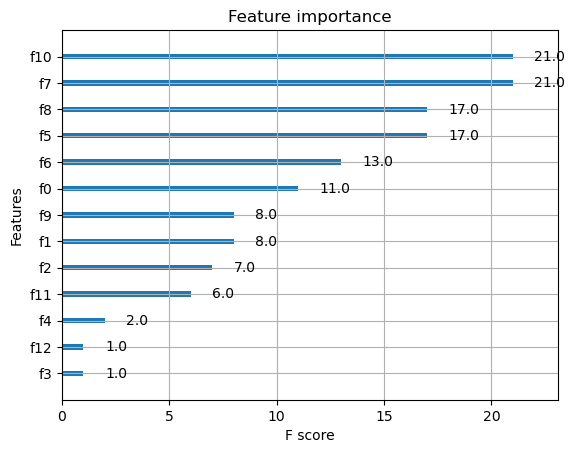

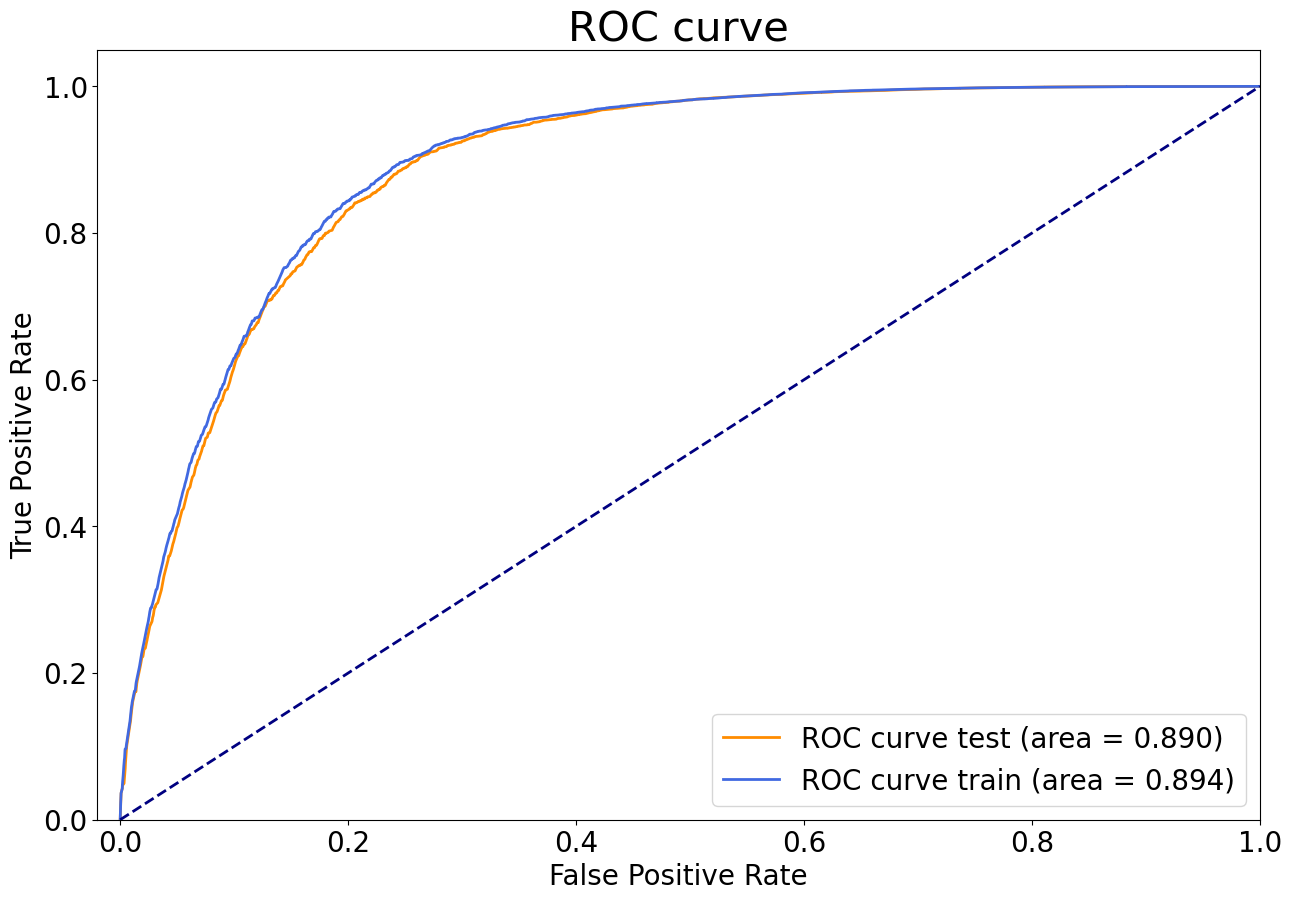

In [25]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(MC_events[events_test]["label"], check, sample_weight=abs(MC_events[events_test]["weight"]))
fpr_train, tpr_train, _train = roc_curve(MC_events[events_train]["label"], check_train, sample_weight=abs(MC_events[events_train]["weight"]))
roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)
xgboost.plot_importance(bdt)
lw = 2
fig = plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve test (area = %0.3f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='royalblue',
         lw=lw, label='ROC curve train (area = %0.3f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC curve', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()
if not SAVE: fig.savefig("plots/ROC.pdf")

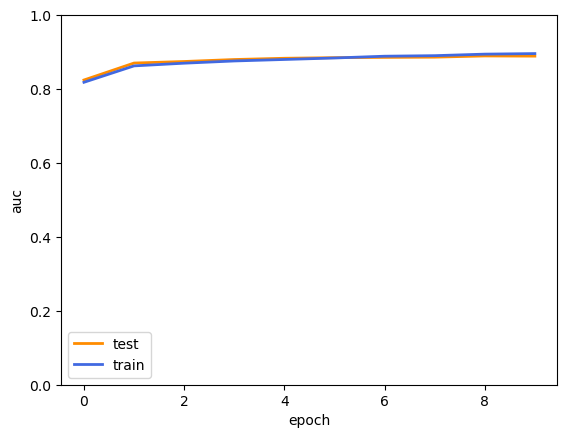

In [26]:
plt.figure()
key="auc"
plt.plot(np.arange(len(progress["test"][key])), progress["test"][key], color="darkorange", lw=lw, label='test')
plt.plot(np.arange(len(progress["train"][key])), progress["train"][key], color="royalblue", lw=lw, label='train')
plt.xlabel("epoch")
plt.ylabel(key)
if key == 'auc':
    plt.ylim([0., 1.0])
elif key == "error":
    plt.ylim([0.15, 0.5])
    
plt.legend()
plt.show()

In [27]:
del features_train 
del features_test 
del d_train 
del d_test 

In [28]:
# Predict
features = awkward.to_numpy(MC_events[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
MC_events["mva_score"] = bdt.predict(xgboost.DMatrix(features))

In [29]:
# Rescale the train QCD to its original weight
MC_events[events_train]["weight"] = awkward.where(
            MC_events[events_train].proc_id != -3,
            MC_events[events_train].weight,
            MC_events[events_train].weight * 50
    )

In [30]:
MC_events["square_weight"] = MC_events.weight ** 2

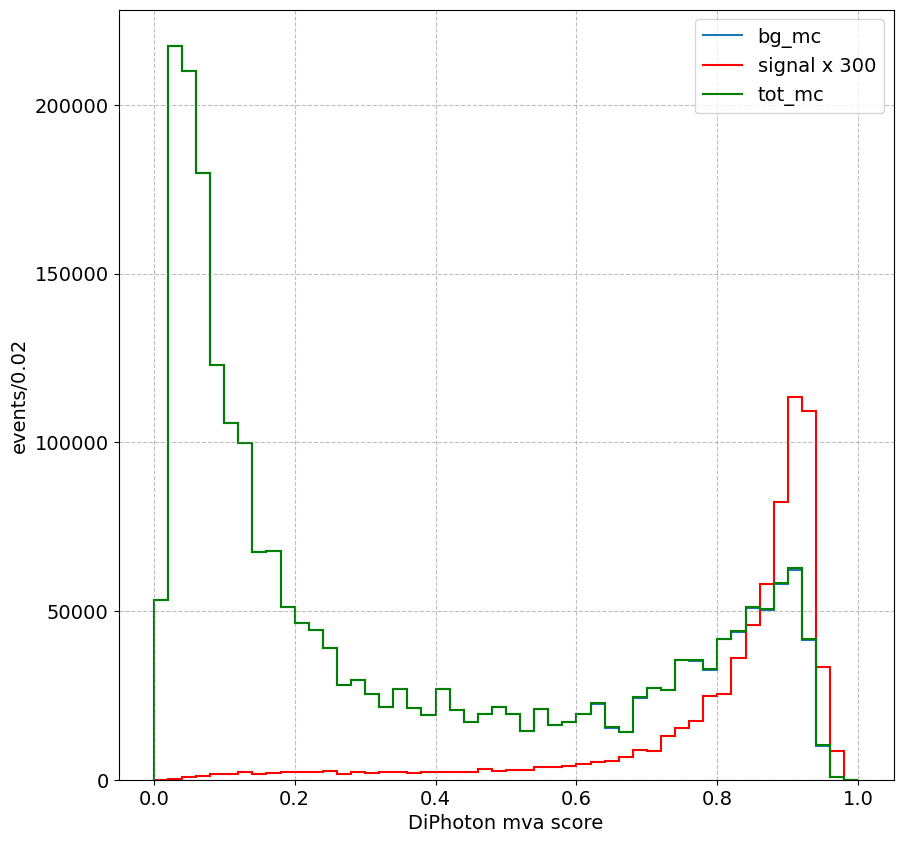

<Figure size 640x480 with 0 Axes>

In [31]:
#bdt_score
fig, axs = plt.subplots(1,1, figsize=(10, 10))
min_ = 0
max_ = 1
nbins = 50
h_bdt_score_tot = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_bg = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot.fill(bdt_score_tot = MC_events.mva_score, weight = MC_events.weight)
#h_bdt_score_tot.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > -3)], weight = MC_events.weight[(MC_events.proc_id > -3)])
#h_bdt_score_tot.fill(bdt_score_tot = qcd.mva_score, weight = qcd.weight)
h_bdt_score_tot_err.fill(bdt_score_tot = MC_events.mva_score, weight = MC_events.square_weight)
h_bdt_score_sig.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)])
h_bdt_score_bg.fill( bdt_score_tot = MC_events.mva_score[(MC_events.proc_id < 0)], weight = MC_events.weight[(MC_events.proc_id < 0)])

h_bdt_score_sig = h_bdt_score_sig * 300

h_bdt_score_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
h_bdt_score_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 300")
h_bdt_score_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")


axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)
axs.set_ylabel('events')
axs.set_xlabel('DiPhoton mva score', fontsize=14)
axs.set_ylabel('events/0.02', fontsize=14)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
plt.plot()
plt.show()
plt.savefig("plots/mva_score_sig_bg.pdf")

In [32]:
qcd["weight"] 

<Array [597, 593, 785, 804, ... 598, 455, 498] type='2333 * float64'>

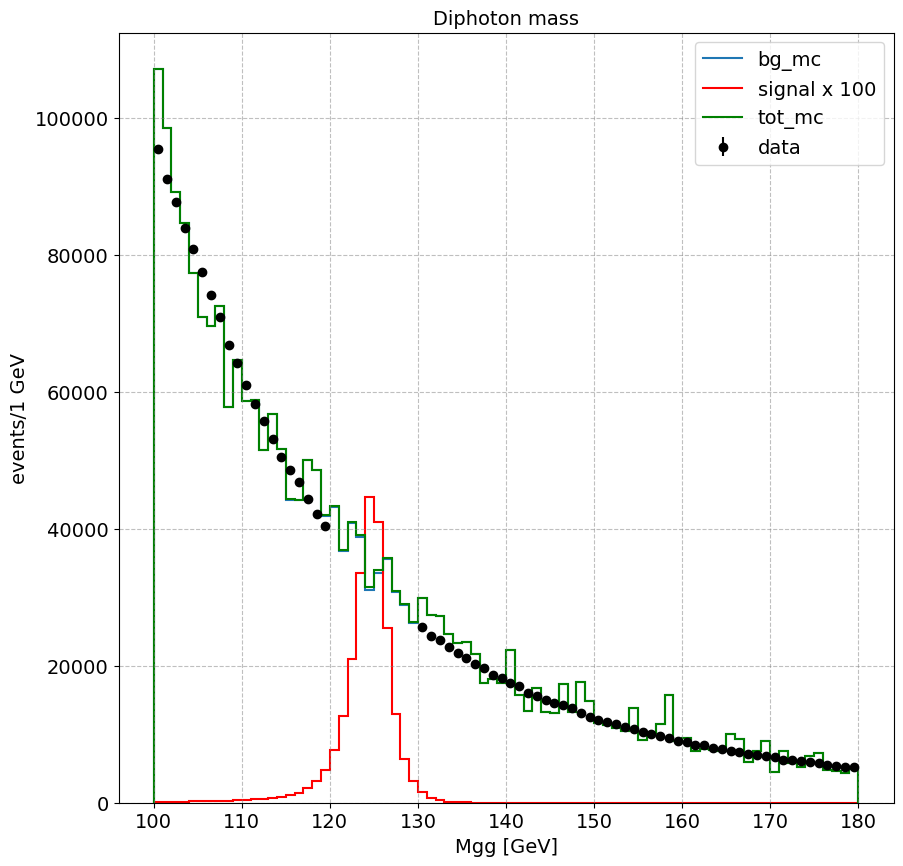

In [58]:
#bdt_score
fig, axs = plt.subplots(1,1, figsize=(10, 10))
min_ = 100
max_ = 180
nbins = 80
h_mass_tot = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_tot_err = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_sig = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_bg = hist.Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_mass_tot.fill(bdt_score_tot = MC_events.CMS_hgg_mass, weight = MC_events.weight)
#h_mass_tot.fill(bdt_score_tot = MC_events.CMS_hgg_mass[MC_events.proc_id > -3], weight = MC_events.weight[MC_events.proc_id > -3])
#h_mass_tot.fill(bdt_score_tot = qcd.Diphoton_mass, weight = qcd.weight)
h_mass_tot_err.fill(bdt_score_tot = MC_events.CMS_hgg_mass, weight = MC_events.square_weight)
#h_mass_tot_err.fill(bdt_score_tot = qcd.Diphoton_mass, weight = qcd.square_weight)
h_mass_sig.fill(bdt_score_tot = MC_events.CMS_hgg_mass[MC_events.proc_id > 0], weight = MC_events.weight[MC_events.proc_id > 0])
h_mass_bg.fill( bdt_score_tot = MC_events.CMS_hgg_mass[MC_events.proc_id < 0], weight = MC_events.weight[MC_events.proc_id < 0])

h_mass_sig = h_mass_sig * 100

h_mass_bg.project("bdt_score_tot").plot(ax=axs, label="bg_mc")
h_mass_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 100")
h_mass_tot.project("bdt_score_tot").plot(ax=axs, color="green", label="tot_mc")

h_mass_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_mass_data.fill(bdt_score_tot=data_events.CMS_hgg_mass, weight=data_events.weight)

bins_data, edges_data = h_mass_data.to_numpy()
bins_err   = np.sqrt(bins_data)
edges_data = np.resize(edges_data, nbins)
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
dump = np.logical_or((edges_data < 120),(edges_data > 130))
axs.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")

axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)
axs.set_ylabel('events')
axs.set_title('Diphoton mass', fontsize=14)
axs.set_xlabel('Mgg [GeV]', fontsize=14)
axs.set_ylabel('events/1 GeV', fontsize=14)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/mgg_sig_bg.pdf")

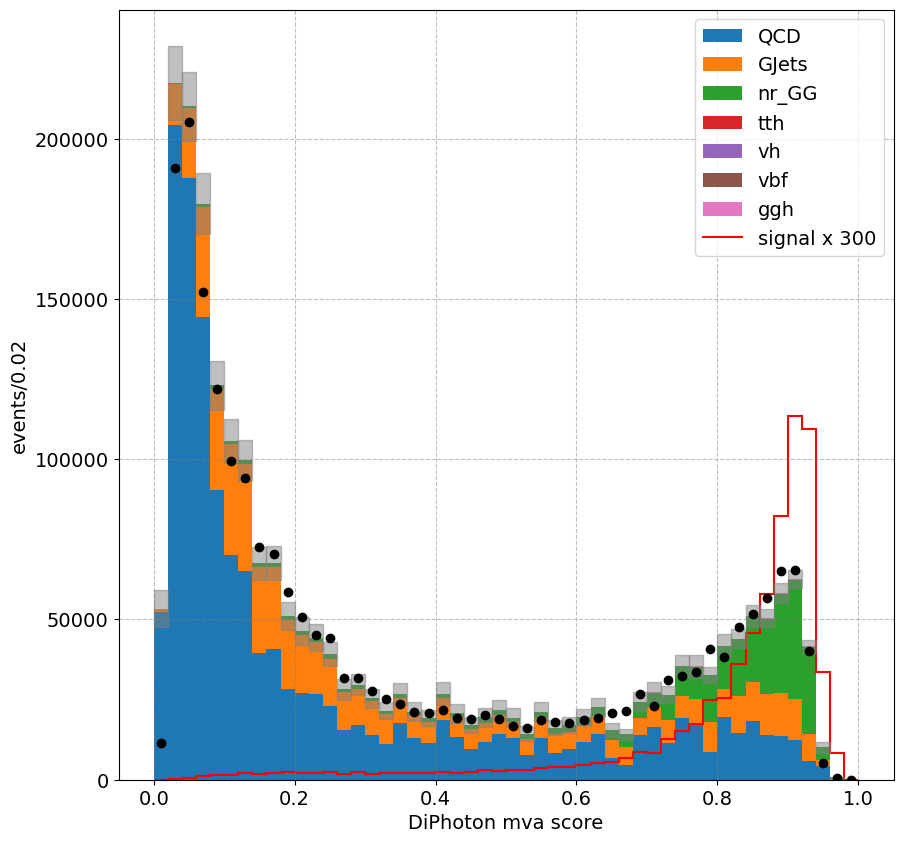

In [60]:
#bdt_score
fig, axs = plt.subplots(1,1, figsize=(10, 10))

min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="bdt_score_tot")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 2)], weight=MC_events.weight[(MC_events.proc_id == 2)], c="ggh")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 3)], weight=MC_events.weight[(MC_events.proc_id == 3)], c="tth")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 4)], weight=MC_events.weight[(MC_events.proc_id == 4)], c="vbf")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)], c="vh")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -1)], weight=MC_events.weight[(MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -2)], weight=MC_events.weight[(MC_events.proc_id == -2)], c="GJets")
full_hist.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="QCD")
#full_hist.fill(bdt_score_tot = qcd.mva_score, weight=qcd.weight, c="QCD")

h_bdt_score_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "bdt_score_tot", label = "tot"))
h_bdt_score_tot_err.fill(bdt_score_tot = MC_events.mva_score, weight = MC_events.square_weight)
# h_bdt_score_tot_err.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > -3)], weight = MC_events.square_weight[(MC_events.proc_id > -3)])
# h_bdt_score_tot_err.fill(bdt_score_tot = qcd.mva_score, weight = qcd.square_weight)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=axs, stack=True, histtype="fill")
h_bdt_score_sig.project("bdt_score_tot").plot(ax=axs, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

mc["bins"]["tot"] = h_bdt_score_tot.to_numpy()[0]
mc["edges"]["tot"] = h_bdt_score_tot.to_numpy()[1] + 0.01
mc["errs"]["tot"] = np.sqrt(h_bdt_score_tot_err.to_numpy()[0])

ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    axs.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

features = awkward.to_numpy(data_events[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
data_events["mva_score"] = bdt.predict(xgboost.DMatrix(features))

h_bdt_score_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_data.fill(bdt_score_tot=data_events.mva_score, weight=data_events.weight)

bins_data, edges_data = h_bdt_score_data.to_numpy()
bins_err   = np.sqrt(bins_data)
edges_data = np.resize(edges_data, nbins)
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
dump = np.logical_or((edges_data < 120),(edges_data > 130))
axs.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
axs.set_ylabel('events')
axs.set_xlabel('DiPhoton mva score', fontsize=14)
axs.set_ylabel('events/0.02', fontsize=14)
axs.tick_params(axis='x', labelsize=14)
axs.tick_params(axis='y', labelsize=14)
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/mva_score_sig_bg_stack.pdf")

/tmp/ipykernel_24168/1484202425.py:25: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(mc["edges"]["tot"][:-1], mc["bins"]["tot"]/mc["bins"]["tot"], color="grey", marker="_", linestyle="", label="mc")
/tmp/ipykernel_24168/1484202425.py:26: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], bins_data / mc["bins"]["tot"], yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/1484202425.py:30: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


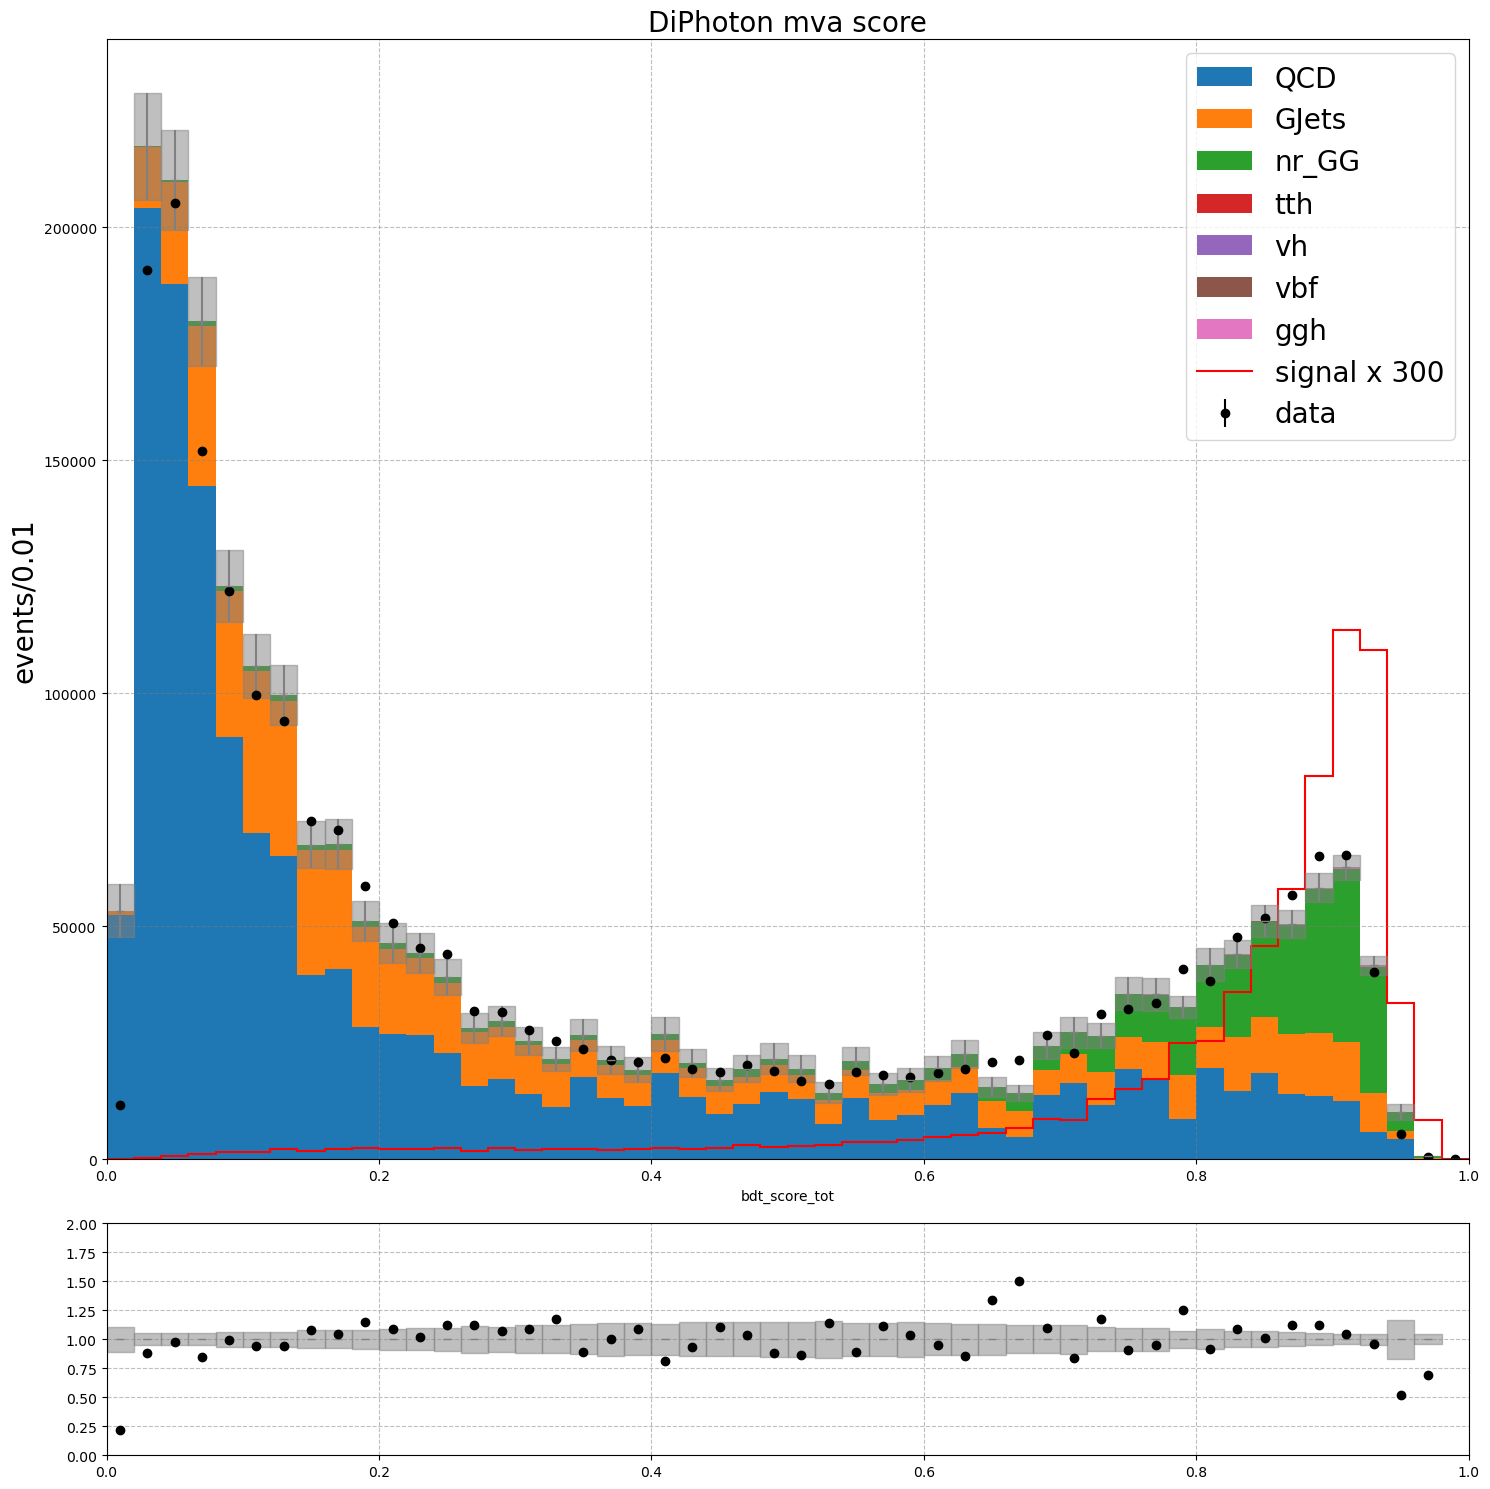

In [61]:
# plot it
#print(full_hist)
fig = plt.figure(figsize=(15, 15))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)
ax0.errorbar(edges_data[dump], bins_data, yerr=bins_err, color="black", marker="o", linestyle="", label="data")
h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_bdt_score_sig.project("bdt_score_tot").plot(ax=ax0, color="red", label="signal x 300")
 
ax0.set_ylabel('events')
ax0.set_title('DiPhoton mva score', fontsize=20)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)


ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)

ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 20})
ax0.grid(color='grey', linestyle='--', alpha=0.5)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.plot(mc["edges"]["tot"][:-1], mc["bins"]["tot"]/mc["bins"]["tot"], color="grey", marker="_", linestyle="", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], bins_data / mc["bins"]["tot"], yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
# ax1.fill_between(mc["edges"]["tot"][:-1], mc["bins"]["tot"]/mc["bins"]["tot"]-mc["errs"]["tot"]/mc["bins"]["tot"], mc["bins"]["tot"]/mc["bins"]["tot"] + mc["errs"]["tot"]/mc["bins"]["tot"], facecolor='grey', alpha=0.4)

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

# center the bins
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=20)
ax1.set_ylim([0,2])
ax1.set_xlim([0,1])
ax0.set_xlim([0,1])
plt.tight_layout()
plt.savefig("plots/mva_score_sig_bg_stack_ratio.pdf")

# Train and test overlay

/tmp/ipykernel_24168/3366475642.py:75: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - 0.01, x + 0.01], [ydn[set][i]/mc["bins"]["train"][i], ydn[set][i]/mc["bins"]["train"][i]], [yup[set][i]/mc["bins"]["train"][i], yup[set][i]/mc["bins"]["train"][i]], facecolor=colors[j], alpha=0.3, edgecolor=colors[j], label="MC stat unc.")
/tmp/ipykernel_24168/3366475642.py:78: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["val"]/mc["bins"]["train"], yerr=abs(mc["errs"]["val"]/mc["bins"]["train"]), color="lawngreen", marker="+", linestyle="", label="training")
/tmp/ipykernel_24168/3366475642.py:79: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["train"]/mc["bins"]["train"], yerr=abs(mc["errs"]["train"]/mc["bins"]["train"]), color="red", marker="+", linestyle="", label="training")
/tmp/ipykernel_24168/3366475642.py:80: RuntimeWarning: invali

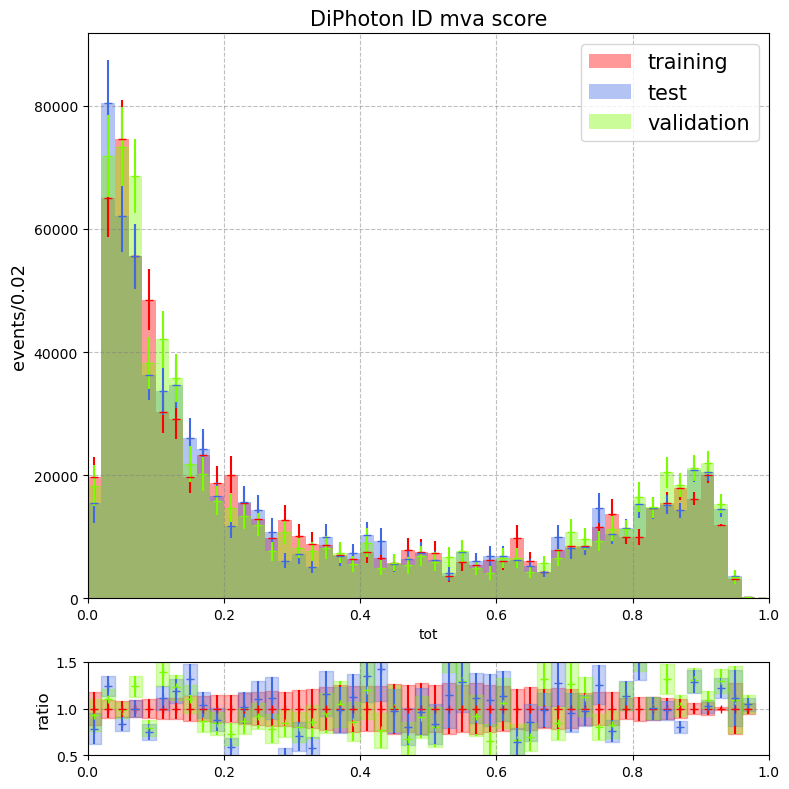

In [36]:
#bdt_score
min_ = 0
max_ = 1
nbins = 50

h_bdt_score_tot_train = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err_train = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig_train = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_test = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err_test = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig_test = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_val = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot_err_val = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))
h_bdt_score_sig_val = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="bdt_score_tot", label="tot"))

h_bdt_score_tot_train.fill(bdt_score_tot = MC_events.mva_score[MC_events.train_split == 0], weight = MC_events.weight [MC_events.train_split == 0])
h_bdt_score_tot_err_train.fill(bdt_score_tot = MC_events.mva_score[MC_events.train_split == 0], weight = MC_events.square_weight[MC_events.train_split == 0])
h_bdt_score_sig_train.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > 0) & (MC_events.train_split == 0)], weight = MC_events.weight[(MC_events.proc_id > 0) & (MC_events.train_split == 0)])

h_bdt_score_tot_test.fill(bdt_score_tot = MC_events.mva_score[MC_events.train_split == 1], weight = MC_events.weight[MC_events.train_split == 1])
h_bdt_score_tot_err_test.fill(bdt_score_tot = MC_events.mva_score[MC_events.train_split == 1], weight = MC_events.square_weight[MC_events.train_split == 1])
h_bdt_score_sig_test.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > 0) & (MC_events.train_split == 1)], weight = MC_events.weight[(MC_events.proc_id > 0) & (MC_events.train_split == 1)])

h_bdt_score_tot_val.fill(bdt_score_tot = MC_events.mva_score[MC_events.train_split == 2], weight=MC_events.weight[MC_events.train_split == 2])
h_bdt_score_tot_err_val.fill(bdt_score_tot = MC_events.mva_score[MC_events.train_split == 2], weight=MC_events.square_weight[MC_events.train_split == 2])
h_bdt_score_sig_val.fill(bdt_score_tot = MC_events.mva_score[(MC_events.proc_id > 0) & (MC_events.train_split == 2)], weight = MC_events.weight[(MC_events.proc_id > 0) & (MC_events.train_split == 2)])

h_bdt_score_sig_train = h_bdt_score_sig * 300

fig = plt.figure(figsize=(8, 8))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)
h_bdt_score_tot_train.project("bdt_score_tot").plot(ax=ax0, histtype="fill", color="red", alpha=0.4, label="training", linestyle="-", edgecolor="red")
h_bdt_score_tot_test.project("bdt_score_tot").plot(ax=ax0, histtype="fill", linestyle="-", color="royalblue", alpha=0.4, label="test", edgecolor="royalblue")
h_bdt_score_tot_val.project("bdt_score_tot").plot(ax=ax0, histtype="fill", linestyle="-", color="lawngreen", alpha=0.4, label="validation", edgecolor="lawngreen")
#h_bdt_score_tot_val.project("bdt_score_tot").plot(ax=ax0, histtype="fill", alpha=0.3)
#h_bdt_score_sig_train.project("bdt_score_tot").plot(ax=ax0, histtype="fill")
#h_bdt_score_sig_train.project("bdt_score_tot").plot(ax=ax0, color="red", label="signal x 300")
 
ax0.set_ylabel('events')
ax0.set_title('DiPhoton ID mva score', fontsize=15)
ax0.set_ylabel('events/0.02', fontsize=13)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)

mc["bins"]["train"] = h_bdt_score_tot_train.to_numpy()[0]
mc["bins"]["test"] = h_bdt_score_tot_test.to_numpy()[0]
mc["bins"]["val"] = h_bdt_score_tot_val.to_numpy()[0]
mc["edges"]["train"] = h_bdt_score_tot_train.to_numpy()[1] + 0.01
mc["edges"]["test"] = h_bdt_score_tot_test.to_numpy()[1] + 0.01
mc["edges"]["val"] = h_bdt_score_tot_val.to_numpy()[1] + 0.01
mc["errs"]["train"] = np.sqrt(h_bdt_score_tot_err_train.to_numpy()[0])
mc["errs"]["test"] = np.sqrt(h_bdt_score_tot_err_test.to_numpy()[0])
mc["errs"]["val"] = np.sqrt(h_bdt_score_tot_err_val.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
yup = {}
ydn = {}
for set in ["train", "test", "val"]:
    ydn[set] = [mc["bins"][set][i] - x for i, x in enumerate(mc["errs"][set])]
    yup[set] = [mc["bins"][set][i] + x for i, x in enumerate(mc["errs"][set])]

ax0.errorbar(mc["edges"]["train"][:-1], mc["bins"]["train"], yerr=mc["errs"]["train"], color="red", marker="_", linestyle="")
ax0.errorbar(mc["edges"]["test"][:-1], mc["bins"]["test"], yerr=mc["errs"]["test"], color="royalblue", marker="_", linestyle="")
ax0.errorbar(mc["edges"]["val"][:-1], mc["bins"]["val"], yerr=mc["errs"]["val"], color="lawngreen", marker="_", linestyle="")

ax0.legend( prop={'size': 15})
ax0.grid(color='grey', linestyle='--', alpha=0.5)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

colors = ["red", "royalblue", "lawngreen"]
for j, set in enumerate(["train", "test", "val"]):
    for i, x in enumerate(mc["edges"][set][:-1]):
        ax1.fill_between([x - 0.01, x + 0.01], [ydn[set][i]/mc["bins"]["train"][i], ydn[set][i]/mc["bins"]["train"][i]], [yup[set][i]/mc["bins"]["train"][i], yup[set][i]/mc["bins"]["train"][i]], facecolor=colors[j], alpha=0.3, edgecolor=colors[j], label="MC stat unc.")


ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["val"]/mc["bins"]["train"], yerr=abs(mc["errs"]["val"]/mc["bins"]["train"]), color="lawngreen", marker="+", linestyle="", label="training")
ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["train"]/mc["bins"]["train"], yerr=abs(mc["errs"]["train"]/mc["bins"]["train"]), color="red", marker="+", linestyle="", label="training")
ax1.errorbar(mc["edges"]["train"][:-1], mc["bins"]["test"]/mc["bins"]["train"], yerr=abs(mc["errs"]["test"]/mc["bins"]["train"]), color="royalblue", marker="+", linestyle="", label="training")
#ax1.fill_between(mc["edges"]["val"][:-1], mc["bins"]["val"]/mc["bins"]["train"]-mc["errs"]["val"]/mc["bins"]["train"], mc["bins"]["val"]/mc["bins"]["train"] + mc["errs"]["val"]/mc["bins"]["train"], facecolor='lawngreen', alpha=0.4)
#ax1.fill_between(mc["edges"]["train"][:-1], mc["bins"]["train"]/mc["bins"]["train"]-mc["errs"]["train"]/mc["bins"]["train"], mc["bins"]["train"]/mc["bins"]["train"] + mc["errs"]["train"]/mc["bins"]["train"], facecolor='red', alpha=0.4)
#ax1.fill_between(mc["edges"]["test"][:-1], mc["bins"]["test"]/mc["bins"]["train"]-mc["errs"]["test"]/mc["bins"]["train"], mc["bins"]["test"]/mc["bins"]["train"] + mc["errs"]["test"]/mc["bins"]["train"], facecolor='royalblue', alpha=0.4)

ax1.set_ylabel('ratio', fontsize=12)
ax1.set_ylim([0.5,1.5])
ax1.set_xlim([0,1])
ax0.set_xlim([0,1])
plt.tight_layout()
plt.savefig("plots/mva_score_test_trai_ratio.pdf")


In [37]:
# Sigma RV
MC_events.fields

['dZ',
 'CMS_hgg_mass',
 'event',
 'pt',
 'eta',
 'phi',
 'LeadPhoton_pt_mgg',
 'LeadPhoton_phi',
 'LeadPhoton_mvaID',
 'SubleadPhoton_pt_mgg',
 'SubleadPhoton_phi',
 'SubleadPhoton_mvaID',
 'Diphoton_cos_dPhi',
 'sigmaMrv',
 'sigmaMwv',
 'PV_score',
 'PV_chi2',
 'nPV',
 'dZ_1',
 'dZ_2',
 'dZ_3',
 'weight',
 'proc_id',
 'label',
 'vtxProb',
 'LeadPhoton_eta',
 'SubleadPhoton_eta',
 'train_split',
 'mva_score',
 'square_weight']

In [38]:
SB_MC = (MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)
SB_DATA = (data_events.CMS_hgg_mass < 115) | (data_events.CMS_hgg_mass > 135)

/tmp/ipykernel_24168/871986115.py:94: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/871986115.py:98: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/871986115.py:101: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


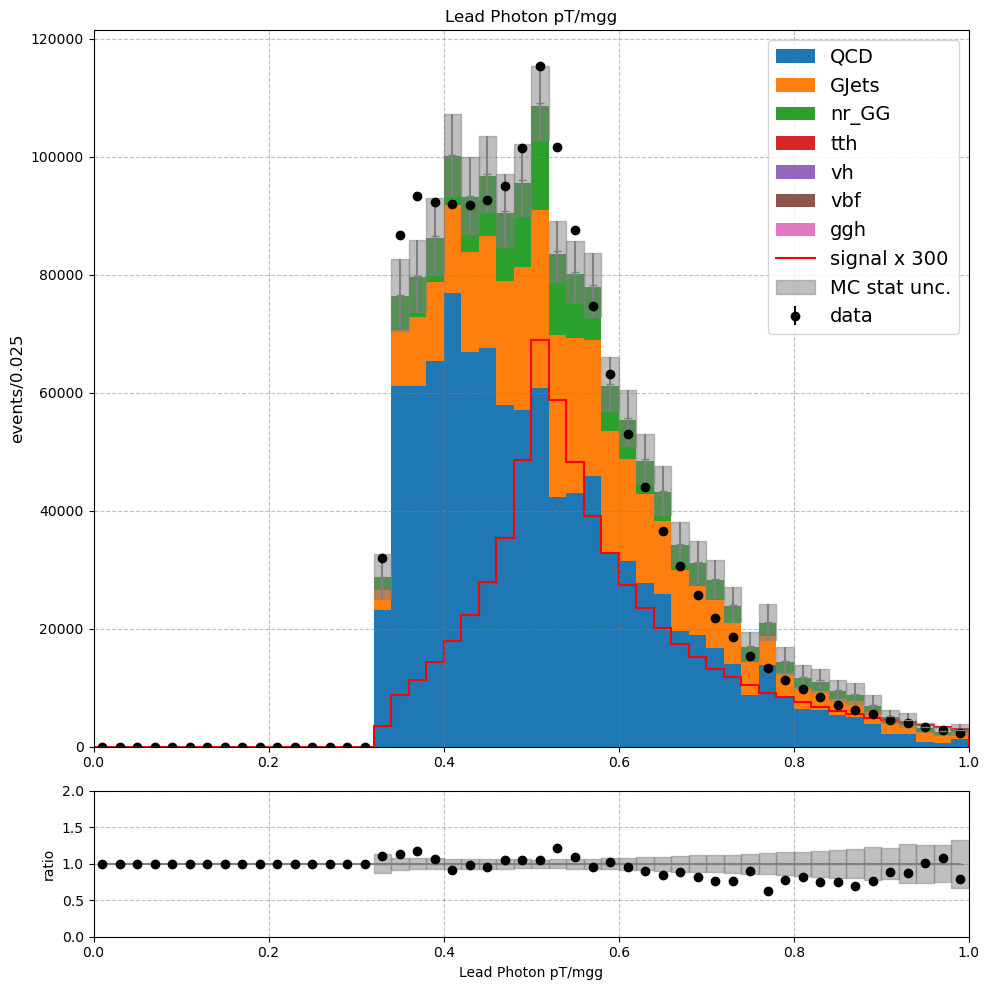

In [39]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="lead_pt_mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], c="QCD")

h_lead_pt_mgg_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label = "tot"))
h_lead_pt_mgg_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label = "tot"))
h_lead_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "lead_pt_mgg", label="tot"))

h_lead_pt_mgg_tot_err.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.square_weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_lead_pt_mgg_tot.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_lead_pt_mgg_sig.fill(lead_pt_mgg = MC_events.LeadPhoton_pt_mgg[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_lead_pt_mgg_sig.project("lead_pt_mgg").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_lead_pt_mgg_tot.to_numpy()[0]
mc["edges"]["tot"] = h_lead_pt_mgg_tot.to_numpy()[1] + 0.01
mc["errs"]["tot"] = np.sqrt(h_lead_pt_mgg_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_lead_pt_mgg_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="lead_pt_mgg", label="tot"))
h_lead_pt_mgg_data.fill(lead_pt_mgg = data_events.LeadPhoton_pt_mgg[(data_events.CMS_hgg_mass < 115) | (data_events.CMS_hgg_mass > 135)], weight = data_events.weight[(data_events.CMS_hgg_mass < 115) | (data_events.CMS_hgg_mass > 135)])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_lead_pt_mgg_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.025', fontsize=12)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon pT/mgg', fontsize=12)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0,2])
ax1.set_xlim([0,1])
ax0.set_xlim([0,1])
ax1.set_xlabel('Lead Photon pT/mgg', fontsize=10)
ax1.set_ylabel('ratio', fontsize=10)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/lead_pt_mgg_sig_bg_stack.pdf")

/tmp/ipykernel_24168/3089051939.py:94: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/3089051939.py:98: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/3089051939.py:101: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


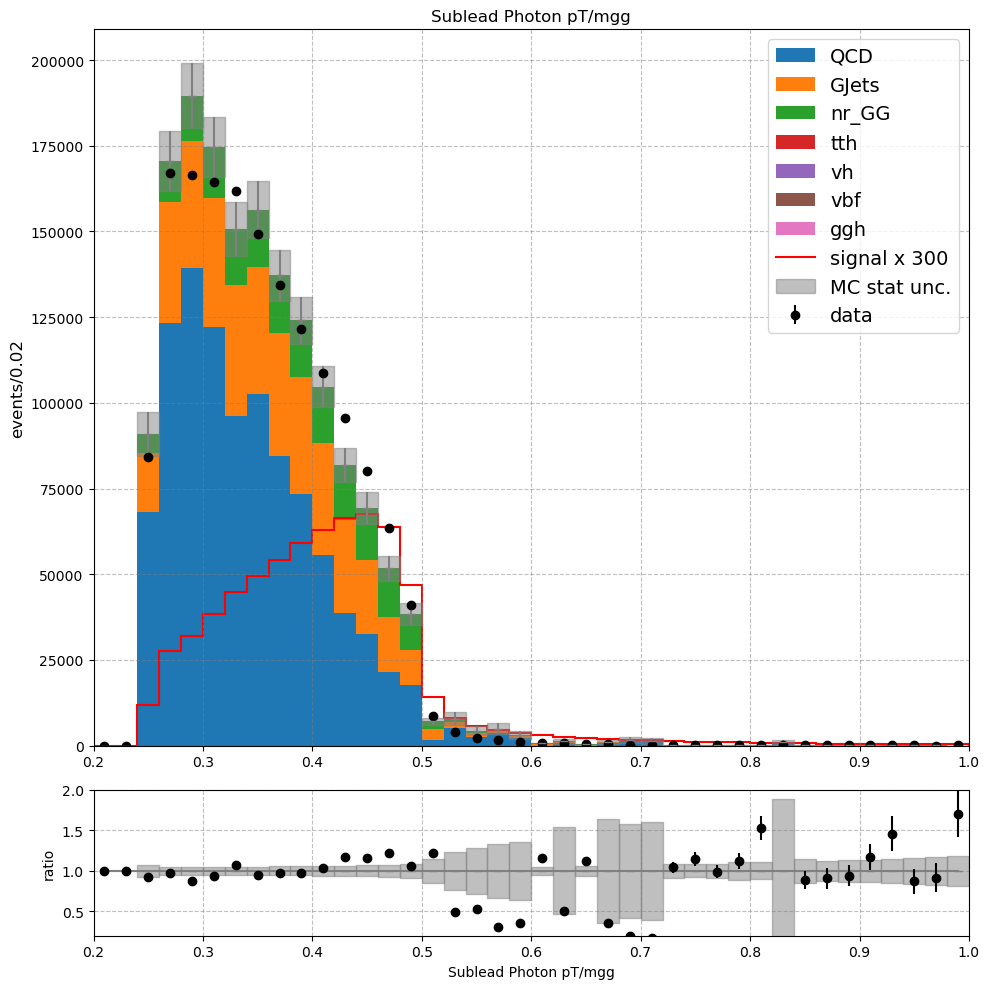

In [40]:
# sublead photon pt/mgg
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 0.2
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="pt_mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], weight=MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135)) & (MC_events.proc_id == -3)], c="QCD")

h_pt_mgg_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "pt_mgg", label = "tot"))
h_pt_mgg_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "pt_mgg", label = "tot"))
h_pt_mgg_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "pt_mgg", label = "tot"))

h_pt_mgg_tot_err.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.square_weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_pt_mgg_tot.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))], weight = MC_events.weight[((MC_events.CMS_hgg_mass < 115) | (MC_events.CMS_hgg_mass > 135))])
h_pt_mgg_sig.fill(pt_mgg = MC_events.SubleadPhoton_pt_mgg[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_pt_mgg_sig.project("pt_mgg").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_pt_mgg_tot.to_numpy()[0]
mc["edges"]["tot"] = h_pt_mgg_tot.to_numpy()[1] + 0.01
mc["errs"]["tot"] = np.sqrt(h_pt_mgg_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - 0.01, x + 0.01], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_pt_mgg_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="lead_pt_mgg", label="tot"))
h_pt_mgg_data.fill(lead_pt_mgg = data_events.SubleadPhoton_pt_mgg[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_pt_mgg_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.02', fontsize=12)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon pT/mgg', fontsize=12)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - 0.01, x + 0.01], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.2,2])
ax1.set_xlim([0.2,1])
ax0.set_xlim([0.2,1])
ax1.set_xlabel('Sublead Photon pT/mgg', fontsize=10)
ax1.set_ylabel('ratio', fontsize=10)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/sublead_pt_mgg_sig_bg_stack.pdf")

/tmp/ipykernel_24168/2458175579.py:96: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/2458175579.py:100: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/2458175579.py:103: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


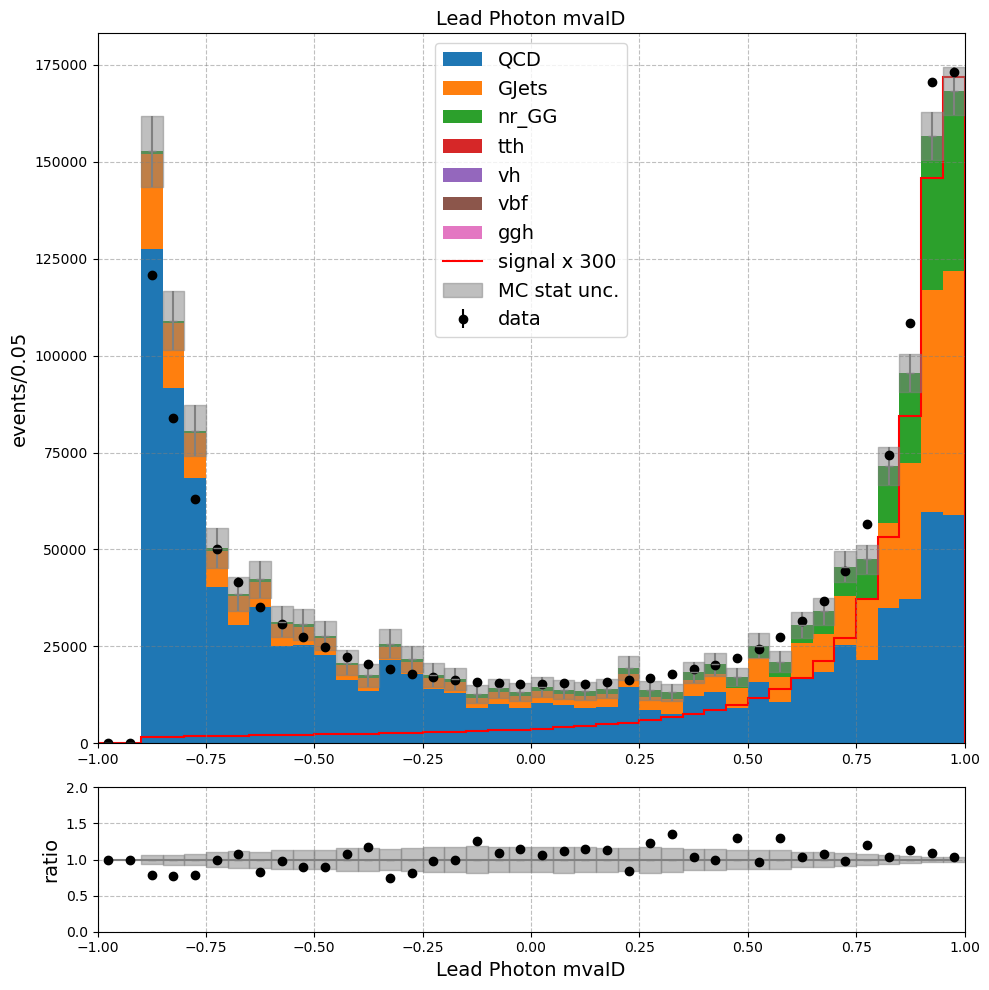

In [41]:
# lead photon mvaID
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -1.
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="mva")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(mva = MC_events.LeadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")

h_mvaID_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))

h_mvaID_tot_err.fill(mva = MC_events.LeadPhoton_mvaID[SB_MC], weight = MC_events.square_weight[SB_MC])
h_mvaID_tot.fill(mva = MC_events.LeadPhoton_mvaID[SB_MC], weight = MC_events.weight[SB_MC])
h_mvaID_sig.fill(mva = MC_events.LeadPhoton_mvaID[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_mvaID_sig.project("mva").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_mvaID_tot.to_numpy()[0]
mc["edges"]["tot"] = h_mvaID_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_mvaID_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_mvaID_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_mvaID_data.fill(mva = data_events.LeadPhoton_mvaID[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_mvaID_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon mvaID', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([-1.,1])
ax0.set_xlim([-1.,1])
ax1.set_xlabel('Lead Photon mvaID', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/lead_mvaID_sig_bg_stack.pdf")

/tmp/ipykernel_24168/1735772435.py:96: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/1735772435.py:100: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/1735772435.py:103: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


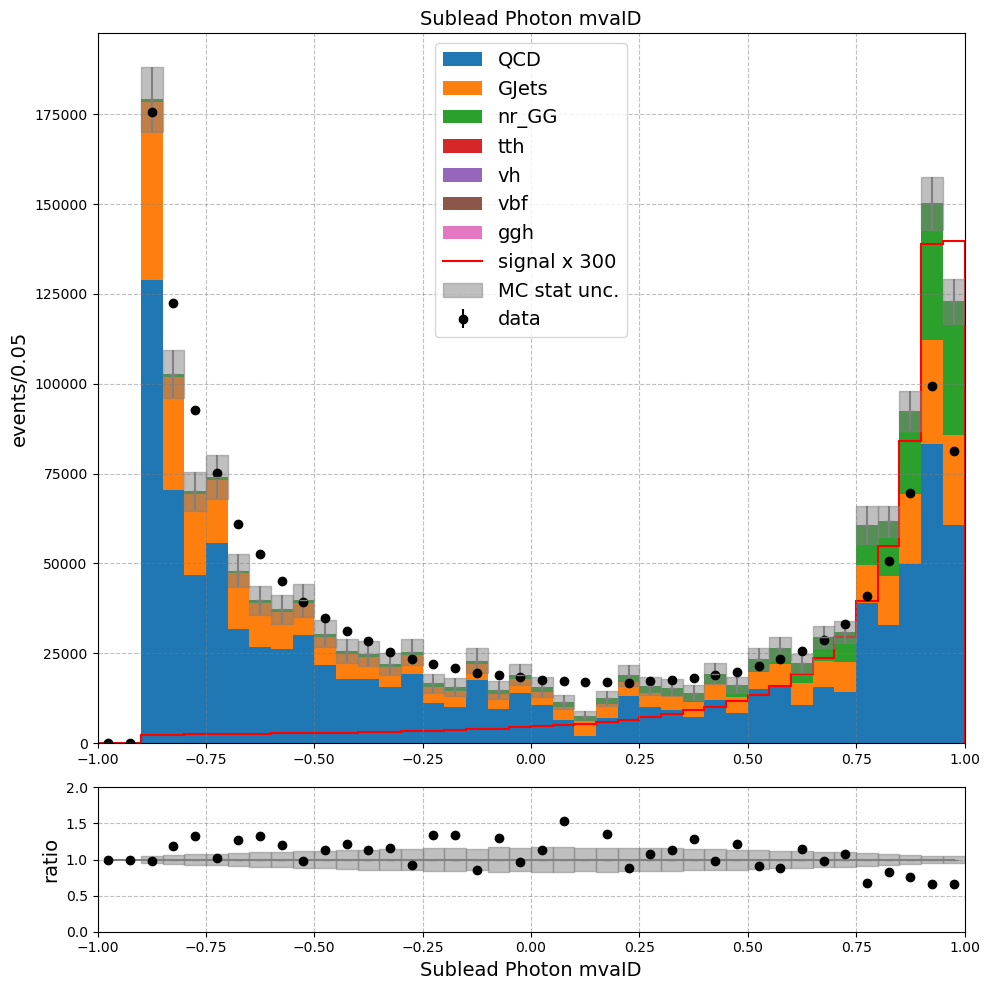

In [42]:
# sublead photon mvaID
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -1.
max_ = 1
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="mva")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(mva = MC_events.SubleadPhoton_mvaID[(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")

h_mvaID_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))
h_mvaID_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "mva", label = "tot"))

h_mvaID_tot_err.fill(mva = MC_events.SubleadPhoton_mvaID[SB_MC], weight = MC_events.square_weight[SB_MC])
h_mvaID_tot.fill(mva = MC_events.SubleadPhoton_mvaID[SB_MC], weight = MC_events.weight[SB_MC])
h_mvaID_sig.fill(mva = MC_events.SubleadPhoton_mvaID[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_mvaID_sig.project("mva").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

h_bdt_score_tot_err
mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_mvaID_tot.to_numpy()[0]
mc["edges"]["tot"] = h_mvaID_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_mvaID_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_mvaID_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_mvaID_data.fill(mva = data_events.SubleadPhoton_mvaID[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_mvaID_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon mvaID', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([-1.,1])
ax0.set_xlim([-1.,1])
ax1.set_xlabel('Sublead Photon mvaID', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/sublead_mvaID_sig_bg_stack.pdf")

/tmp/ipykernel_24168/966440300.py:96: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/966440300.py:100: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/966440300.py:103: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


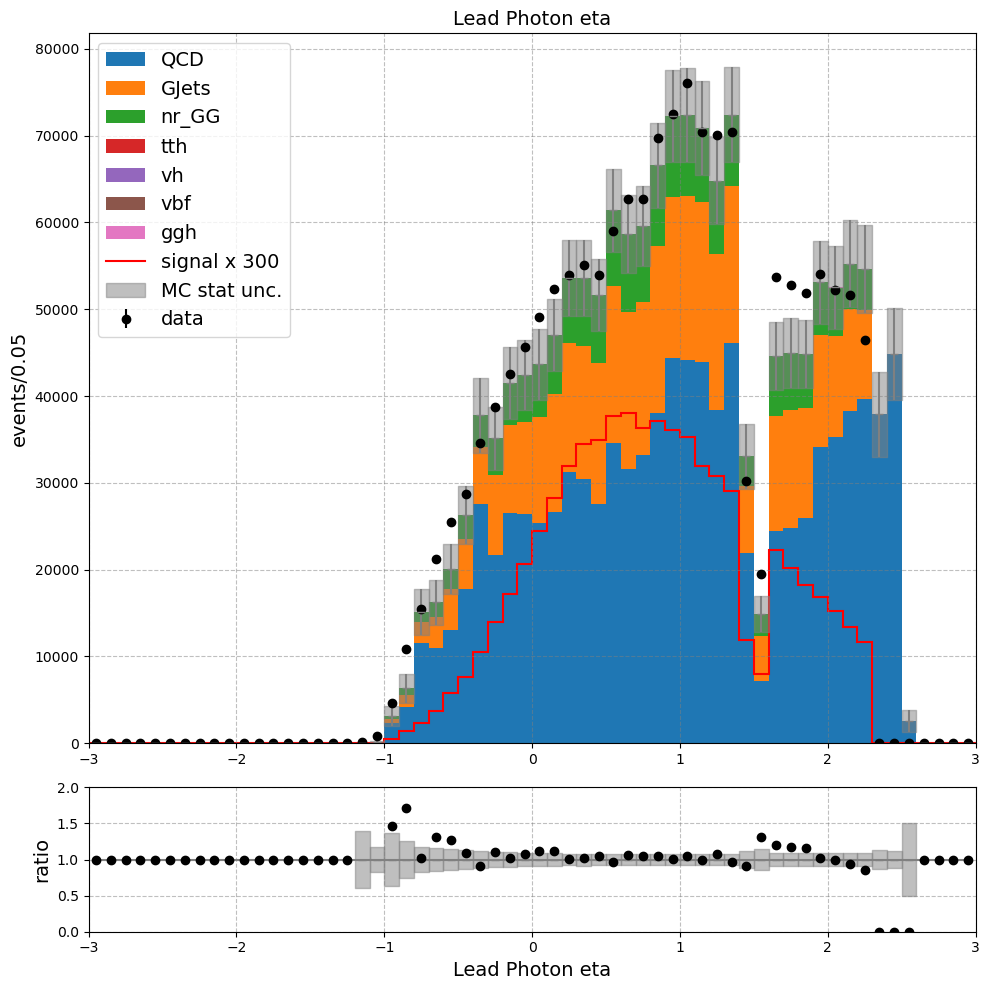

In [43]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_eta"
min_ = -3.
max_ = 3
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(eta = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))

h_eta_tot_err.fill(eta = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(eta = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(eta = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project("eta").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Lead Photon eta', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Lead Photon eta', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/lead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_24168/262921946.py:95: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/262921946.py:99: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/262921946.py:102: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


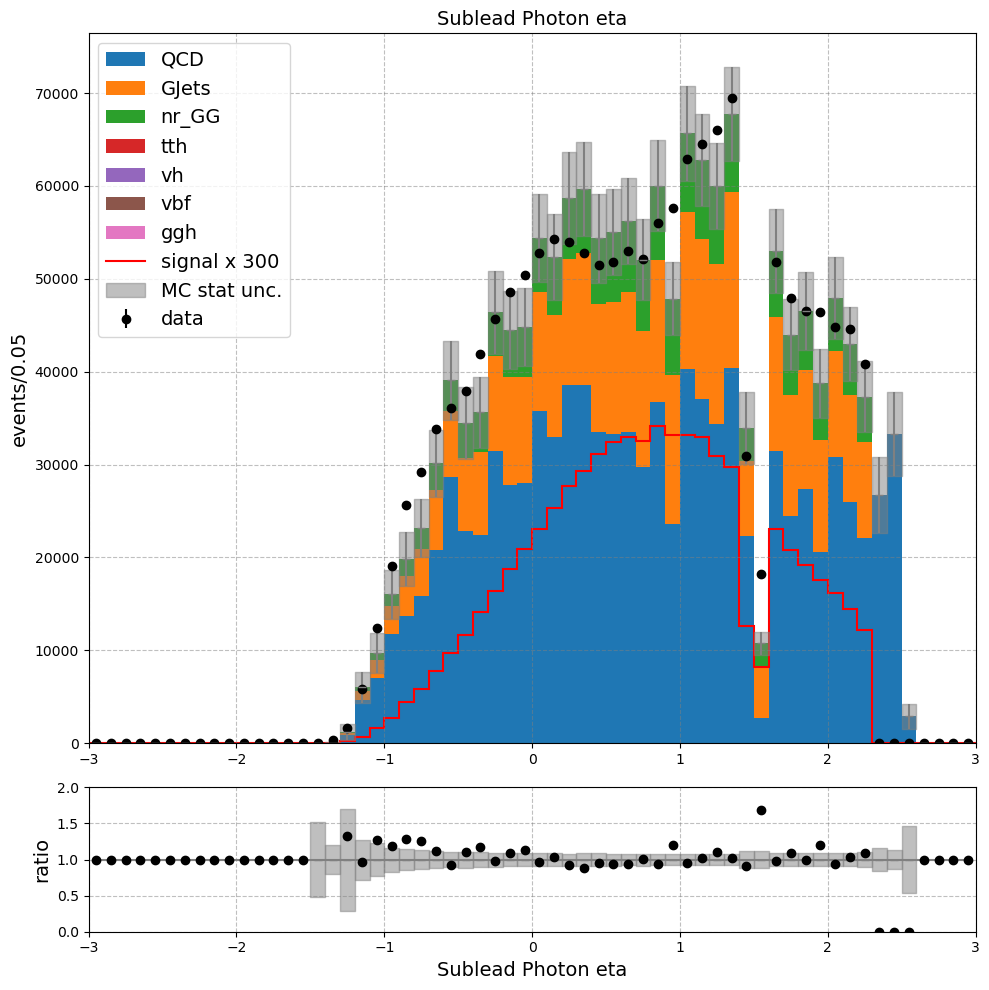

In [44]:
# sublead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -3.
max_ = 3
nbins = 60

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(eta = MC_events.SubleadPhoton_eta[(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = "eta", label = "tot"))

h_eta_tot_err.fill(eta = MC_events.SubleadPhoton_eta[SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(eta = MC_events.SubleadPhoton_eta[SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(eta = MC_events.SubleadPhoton_eta[(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project("eta").plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name="mva", label="tot"))
h_eta_data.fill(mva = data_events.SubleadPhoton_eta[SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel('events/0.05', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sublead Photon eta', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sublead Photon eta', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/sublead_eta_sig_bg_stack.pdf")

/tmp/ipykernel_24168/2320671409.py:101: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/2320671409.py:105: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/2320671409.py:108: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


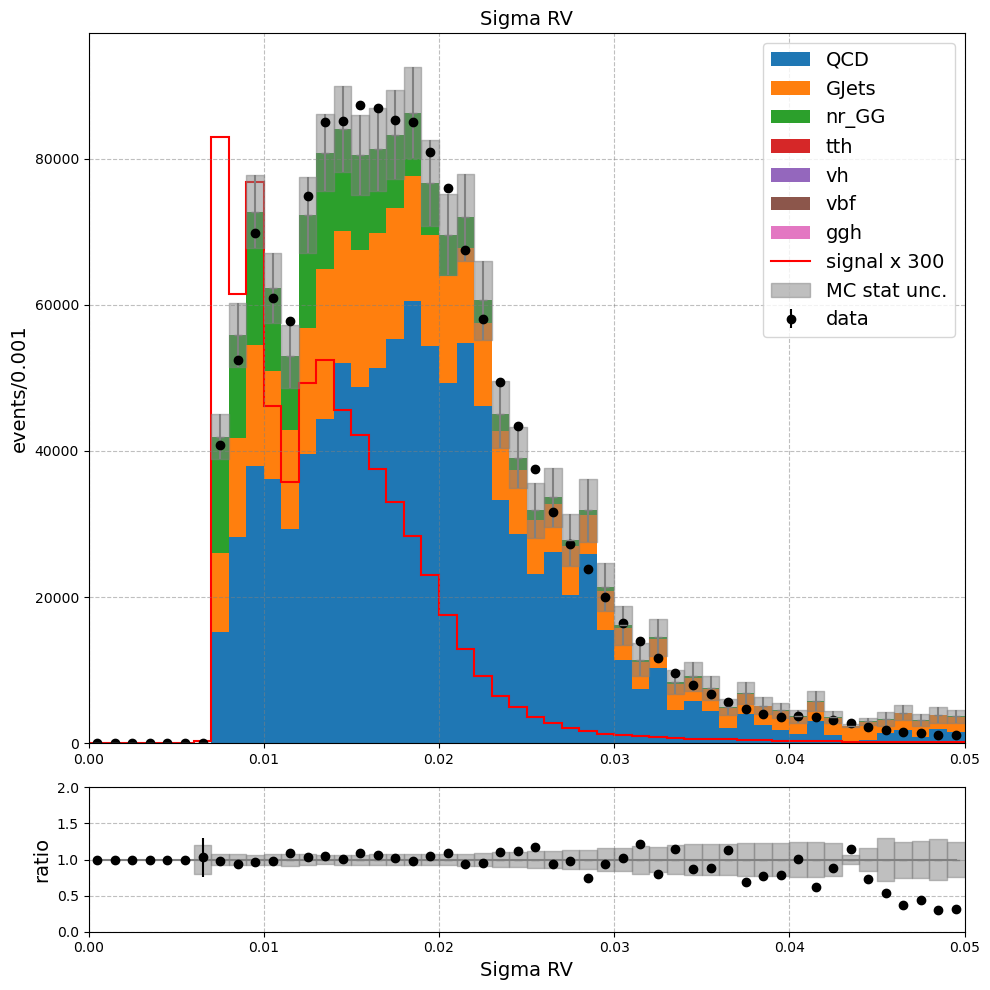

In [45]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "sigmaMrv"
ax_name = "sigma"
min_ = 0
max_ = 0.05
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

qcd = events[((events.Diphoton_mass < 115) | (events.Diphoton_mass > 135)) & (events.process_id == 7)]
norm = ak.sum(MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)])/ak.sum(qcd.weight_central)

full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
#full_hist.fill(sigma = qcd[var], weight=qcd.weight_central*norm, c="QCD")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_eta_tot_err.fill(sigma = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(sigma = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(sigma = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_data.fill(sigma = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{2 * half_bin}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sigma RV', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sigma RV', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/sigmarv_sig_bg_stack.pdf")

/tmp/ipykernel_24168/589232668.py:98: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/589232668.py:102: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/589232668.py:105: RuntimeWarning: invalid value encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


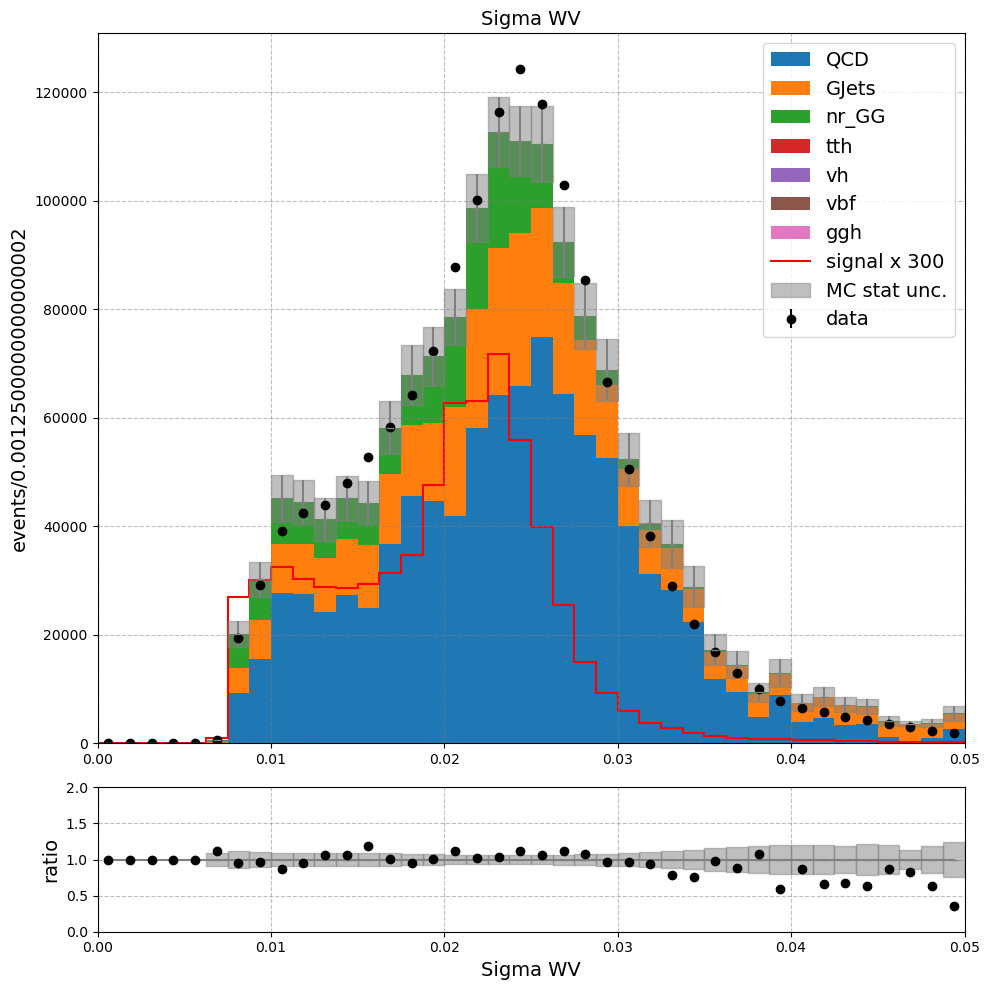

In [46]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "sigmaMwv"
ax_name = "sigma"
min_ = 0
max_ = 0.05
nbins = 40

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
#full_hist.fill(sigma = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")
full_hist.fill(sigma = qcd[var], weight=qcd.weight_central*norm, c="QCD")

h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_eta_tot_err.fill(sigma = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_eta_tot.fill(sigma = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_eta_sig.fill(sigma = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_data.fill(sigma = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{2 * half_bin}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Sigma WV', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('Sigma WV', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/sigmawv_sig_bg_stack.pdf")

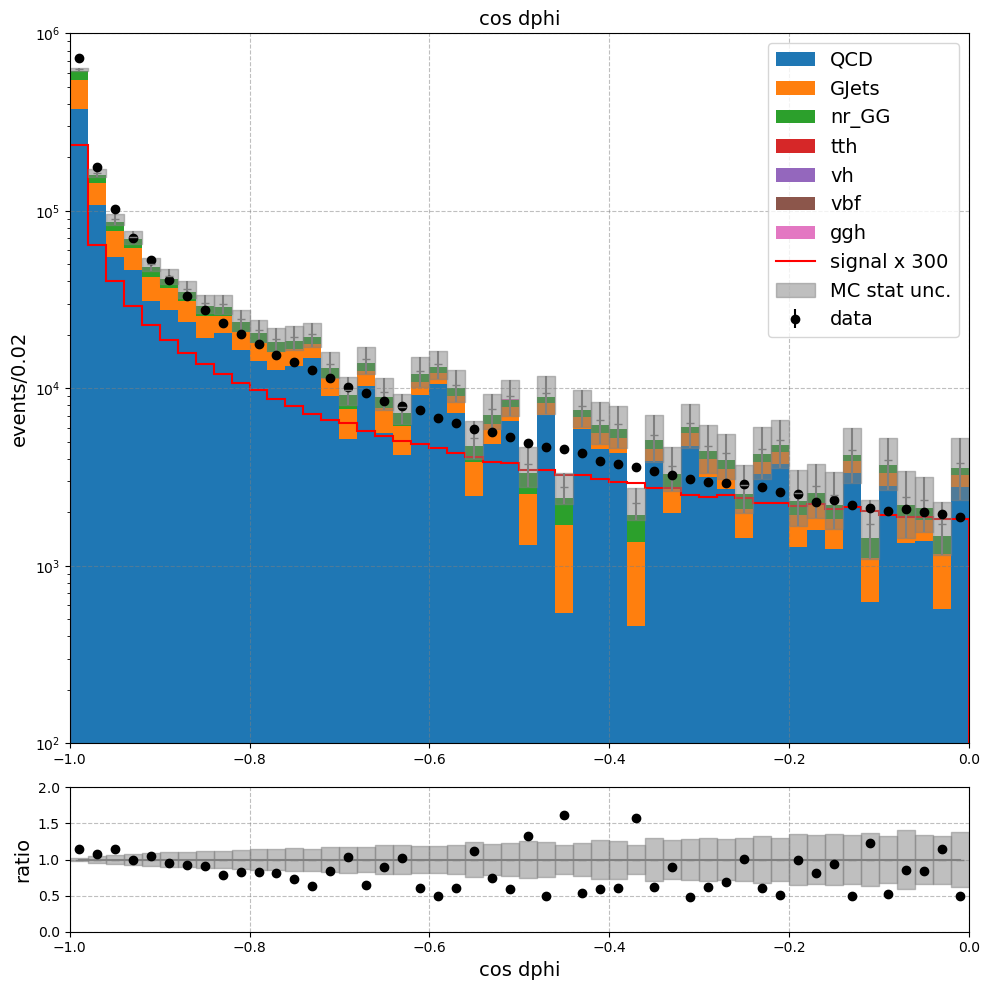

In [47]:
# cos delta phi
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "Diphoton_cos_dPhi"
ax_name = "cosdphi"
min_ = -1
max_ = 0
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(cosdphi = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")

h_cos_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_cos_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_cos_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_cos_tot_err.fill(cosdphi = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_cos_tot.fill(cosdphi = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_cos_sig.fill(cosdphi = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_cos_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_cos_tot.to_numpy()[0]
mc["edges"]["tot"] = h_cos_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_cos_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_cos_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_cos_data.fill(cosdphi = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_cos_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('cos dphi', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax0.set_ylim([1e2,1e6])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax1.set_xlabel('cos dphi', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/cosdphi_sig_bg_stack.pdf")

/tmp/ipykernel_24168/662702470.py:97: RuntimeWarning: invalid value encountered in true_divide
  bins_data / mc["bins"]["tot"],
/tmp/ipykernel_24168/662702470.py:101: RuntimeWarning: invalid value encountered in true_divide
  ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")
/tmp/ipykernel_24168/662702470.py:104: RuntimeWarning: divide by zero encountered in double_scalars
  ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")


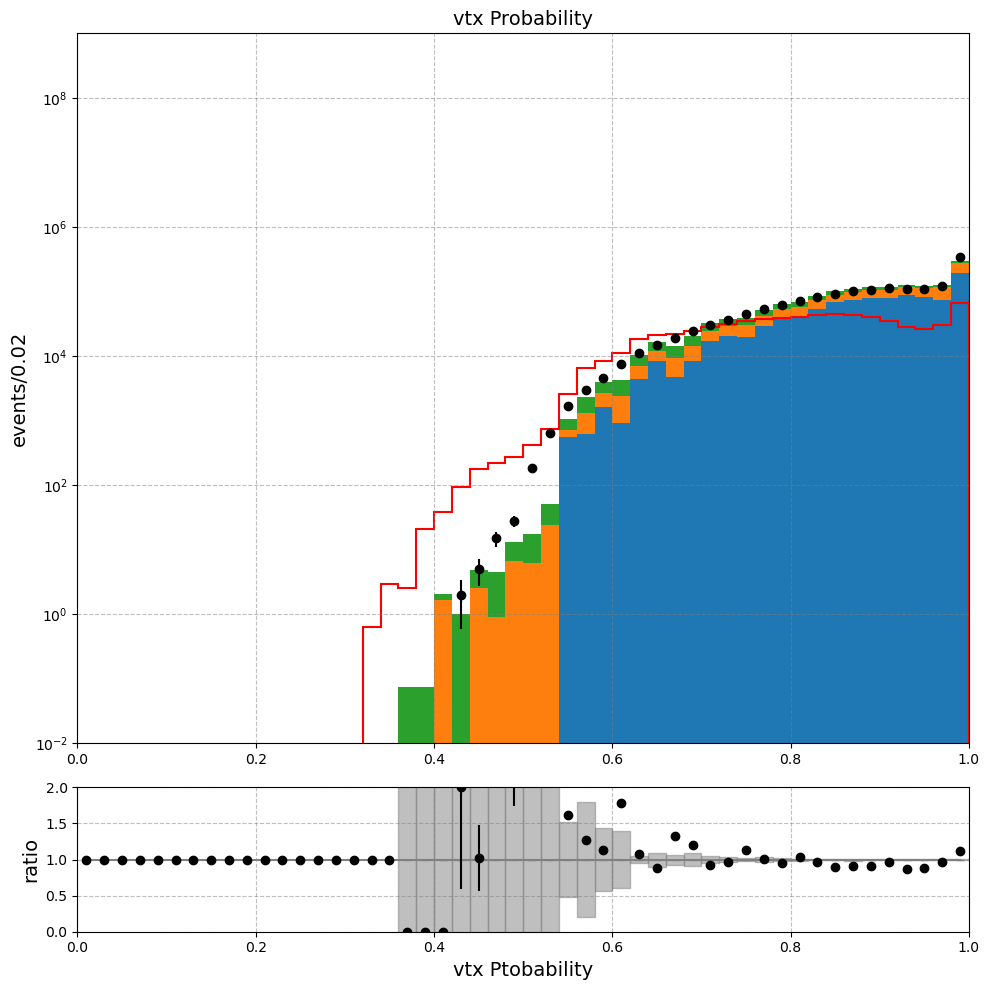

In [48]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "vtxProb"
ax_name = "vtx"
min_ = 0.
max_ = 1.
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 2)], c="ggh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 3)], c="tth")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 4)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 4)], c="vbf")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == 5)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == 5)], c="vh")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -1)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -2)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -2)], c="GJets")
full_hist.fill(vtx = MC_events[var][(SB_MC) & (MC_events.proc_id == -3)], weight=MC_events.weight[(SB_MC) & (MC_events.proc_id == -3)], c="QCD")

h_vtx_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_vtx_tot_err.fill(vtx = MC_events[var][SB_MC], weight = MC_events.square_weight[SB_MC])
h_vtx_tot.fill(vtx = MC_events[var][SB_MC], weight = MC_events.weight[SB_MC])
h_vtx_sig.fill(vtx = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 300)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_vtx_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_vtx_tot.to_numpy()[0]
mc["edges"]["tot"] = h_vtx_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_cos_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
#for i, x in enumerate(mc["edges"]["tot"][:-1]):
#    if i == 0:
#        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
#    else:
#        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_vtx_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_vtx_data.fill(vtx = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_vtx_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 120),(edges_data > 130))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{str(2 * half_bin)[:4]}', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('vtx Probability', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
#ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")

ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax0.set_ylim([1e-2,1e9])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax0.set_yscale('log')
ax1.set_xlabel('vtx Ptobability', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/vtxprob_sig_bg_stack.pdf")

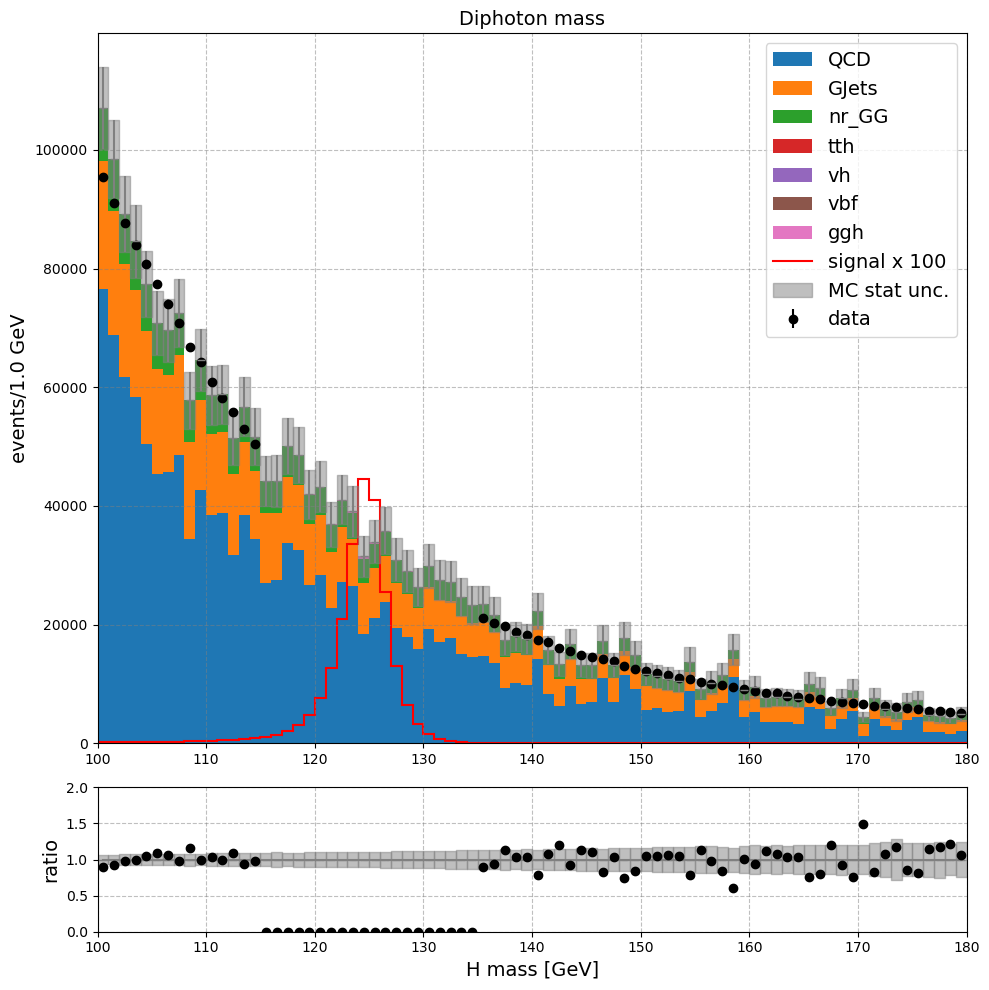

In [68]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "CMS_hgg_mass"
ax_name = "mass"
min_ = 100
max_ = 180
nbins = 80

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "nr_GG", "GJets", "QCD"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 2)], weight=MC_events.weight[(MC_events.proc_id == 2)], c="ggh")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 3)], weight=MC_events.weight[(MC_events.proc_id == 3)], c="tth")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 4)], weight=MC_events.weight[(MC_events.proc_id == 4)], c="vbf")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == 5)], weight=MC_events.weight[(MC_events.proc_id == 5)], c="vh")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -1)], weight=MC_events.weight[(MC_events.proc_id == -1)], c="nr_GG")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -2)], weight=MC_events.weight[(MC_events.proc_id == -2)], c="GJets")
full_hist.fill(mass = MC_events[var][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="QCD")


h_eta_tot_err = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_tot = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_sig = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))

h_eta_tot_err.fill(mass = MC_events[var], weight = MC_events.square_weight)
h_eta_tot.fill(mass = MC_events[var], weight = MC_events.weight)
h_eta_sig.fill(mass = MC_events[var][(MC_events.proc_id > 0)], weight = MC_events.weight[(MC_events.proc_id > 0)] * 100)

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=True, histtype="fill")
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 100")
axs.legend( prop={'size': 14})
axs.grid(color='grey', linestyle='--', alpha=0.5)

mc= {}
mc["bins"] = {}
mc["errs"] = {}
mc["edges"] = {}

# this is useful to manipulate bin content better when doing ratios and error plotting
mc["bins"]["tot"] = h_eta_tot.to_numpy()[0]
mc["edges"]["tot"] = h_eta_tot.to_numpy()[1]
half_bin = np.abs((mc["edges"]["tot"][1] - mc["edges"]["tot"][0])) / 2
mc["edges"]["tot"] = mc["edges"]["tot"] + half_bin
mc["errs"]["tot"] = np.sqrt(h_eta_tot_err.to_numpy()[0])

#create up and down edges to plot shaded area for each bin
ydn = [mc["bins"]["tot"][i] - x for i, x in enumerate(mc["errs"]["tot"])]
yup = [mc["bins"]["tot"][i] + x for i, x in enumerate(mc["errs"]["tot"])]

# plot shaded area for MC errors
for i, x in enumerate(mc["edges"]["tot"][:-1]):
    if i == 0:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.") # we want just one entry in the legend
    else:
        ax0.fill_between([x - half_bin, x + half_bin], [ydn[i], ydn[i]], [yup[i], yup[i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="")

h_eta_data = hist.Hist(hist.axis.Regular(bins = nbins, start = min_, stop = max_, name = ax_name, label = "tot"))
h_eta_data.fill(mass = data_events[var][SB_DATA], weight = data_events.weight[SB_DATA])

# Data plotting
# conversion to numpy because we want the scatter plot
bins_data, edges_data = h_eta_data.to_numpy()
# error calculation
bins_err   = np.sqrt(bins_data)
# eliminate last edge to have same size
edges_data = np.resize(edges_data, nbins)
# center the bins
edges_data = edges_data + half_bin
# blind 
dump = np.logical_or((edges_data < 115),(edges_data > 135))
# plot
ax0.errorbar(edges_data[dump], bins_data[dump], yerr = bins_err[dump], color="black", marker="o", linestyle="", label="data")
   
# cosmetics
ax0.set_ylabel('events')
ax0.set_ylabel(f'events/{2 * half_bin} GeV', fontsize=14)
ax0.set_xlabel('', fontsize=1)
ax0.set_title('Diphoton mass', fontsize=14)
ax0.tick_params(axis='x', labelsize=10)
ax0.tick_params(axis='y', labelsize=10)

# plot error bars
ax0.errorbar(edges_data, mc["bins"]["tot"], yerr=mc["errs"]["tot"] , color="gray", marker="_", linestyle="")
ax0.legend( prop={'size': 14})
ax0.grid(color='grey', linestyle='--', alpha=0.5)

# ratio plot
ax1 = plt.subplot2grid((5, 3), (4, 0), rowspan=1, colspan=3)
ax1.grid(color='grey', linestyle='--', alpha=0.5)

ratio = ak.where(
    mc["bins"]["tot"] != 0,
    bins_data / mc["bins"]["tot"],
    ak.ones_like(mc["bins"]["tot"])
)
ax1.plot(mc["edges"]["tot"][:-1], ak.ones_like(mc["bins"]["tot"]), color="grey", marker="_", linestyle="-", label="mc")
ax1.errorbar(mc["edges"]["tot"][:-1], ratio, yerr = bins_err/mc["bins"]["tot"], color="black", marker="o", linestyle="", label="data")

for i, x in enumerate(mc["edges"]["tot"][:-1]):
    ax1.fill_between([x - half_bin, x + half_bin], [ydn[i]/mc["bins"]["tot"][i], ydn[i]/mc["bins"]["tot"][i]], [yup[i]/mc["bins"]["tot"][i], yup[i]/mc["bins"]["tot"][i]], facecolor='grey', alpha=0.5, edgecolor='grey', label="MC stat unc.")

ax1.set_ylim([0.,2])
ax1.set_xlim([min_, max_])
ax0.set_xlim([min_, max_])
ax1.set_xlabel('H mass [GeV]', fontsize=14)
ax1.set_ylabel('ratio', fontsize=14)
plt.tight_layout()
    
plt.plot()
plt.show()
if not SAVE: fig.savefig("plots/CMS_hgg_mass_sig_bg_stack.pdf")

In [50]:
MC_events["sigmaMrv"][(MC_events.proc_id == -3)]

<Array [0.0141, 0.0143, ... 0.021, 0.00847] type='2333 * ?float64'>

In [51]:
MC_events["n_jets"][(MC_events.proc_id == -3)]

ValueError: key "n_jets" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.3/src/libawkward/util.cpp#L525)

In [ ]:
input_dir ="test_Data_2017_photon_cleaning/merged_nominal.parquet"

events = []
events = awkward.from_parquet(input_dir) 
events = awkward.values_astype(events, np.float64)
data   = events[events.process_id==0]
events = events[events.process_id>0]

norm = awkward.sum(events.weight_central_no_lumi)

In [ ]:
MC_events.LeadPhoton_pt_mgg[(MC_events.proc_id==-3) & (MC_events.sigmaMrv>0.0)]

<Array [0.342, 0.658, 0.802, ... 0.429, 0.48] type='3464 * ?float64'>

In [ ]:
events.LeadPhoton_pt_mgg[(events.process_id>7) & (events.sigmaMrv>0.0)]

<Array [0.71, 0.573, 0.514, ... 0.965, 0.452] type='34188 * float64'>

471

In [ ]:
MC_events.fields

['dZ',
 'CMS_hgg_mass',
 'event',
 'pt',
 'eta',
 'phi',
 'LeadPhoton_pt_mgg',
 'LeadPhoton_phi',
 'LeadPhoton_mvaID',
 'SubleadPhoton_pt_mgg',
 'SubleadPhoton_phi',
 'SubleadPhoton_mvaID',
 'Diphoton_cos_dPhi',
 'sigmaMrv',
 'sigmaMwv',
 'PV_score',
 'PV_chi2',
 'nPV',
 'dZ_1',
 'dZ_2',
 'dZ_3',
 'weight',
 'proc_id',
 'label',
 'vtxProb',
 'LeadPhoton_eta',
 'SubleadPhoton_eta',
 'train_split',
 'mva_score',
 'square_weight']

In [ ]:
e = ak.from_parquet(proc_dict["QCD_M125_2017"]["file"])

In [ ]:
events.fields

['Diphoton_mass',
 'Diphoton_pt',
 'Diphoton_eta',
 'Diphoton_phi',
 'Diphoton_dR',
 'Diphoton_pt_mgg',
 'Diphoton_cos_dPhi',
 'LeadPhoton_pt',
 'LeadPhoton_eta',
 'LeadPhoton_phi',
 'LeadPhoton_mass',
 'LeadPhoton_mvaID',
 'LeadPhoton_pixelSeed',
 'LeadPhoton_pt_mgg',
 'SubleadPhoton_pt',
 'SubleadPhoton_eta',
 'SubleadPhoton_phi',
 'SubleadPhoton_mass',
 'SubleadPhoton_mvaID',
 'SubleadPhoton_pixelSeed',
 'SubleadPhoton_pt_mgg',
 'sigmaMrv',
 'sigmaMwv',
 'vtxProb',
 'bdt_score',
 'PV_score',
 'PV_chi2',
 'nPV',
 'dZ_1',
 'dZ_2',
 'dZ_3',
 'jet_1_pt',
 'jet_1_eta',
 'jet_1_phi',
 'jet_1_mass',
 'jet_1_btagDeepFlavB',
 'jet_1_btagDeepFlavCvB',
 'jet_1_btagDeepFlavCvL',
 'jet_2_pt',
 'jet_2_eta',
 'jet_2_phi',
 'jet_2_mass',
 'jet_2_btagDeepFlavB',
 'jet_2_btagDeepFlavCvB',
 'jet_2_btagDeepFlavCvL',
 'n_jets',
 'is_ggH_BSM',
 'is_ggH_Zerojets_lowPt',
 'is_ggH_Zerojets_highPt',
 'is_ggH_Onejets_lowPt',
 'is_ggH_Onejets_medPt',
 'is_ggH_Onejets_highPt',
 'is_ggH_GETwojets_lowmjj_lowPt',


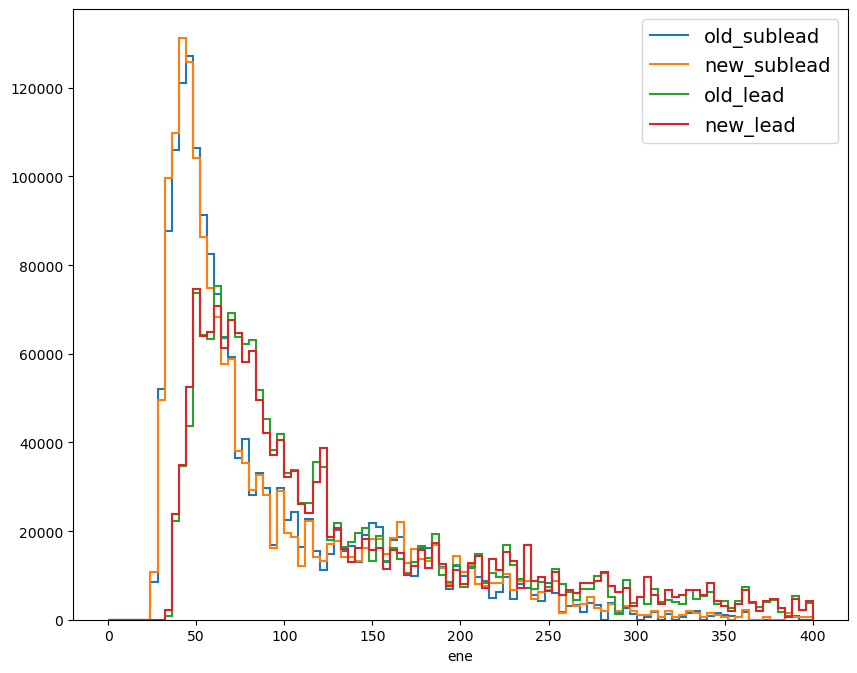

In [ ]:
# vtx prob
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "LeadPhoton_energy"
ax_name = "ene"
min_ = 0.
max_ = 400.
nbins = 100

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_pt_mgg"
full_hist.fill(ene = qcd_events[var1] * np.cosh(qcd_events.LeadPhoton_eta) * qcd_events.CMS_hgg_mass, weight=qcd_events.weight, c="new_lead")
full_hist.fill(ene = MC_events[var1][(MC_events.proc_id == -3)] * np.cosh(MC_events.LeadPhoton_eta[(MC_events.proc_id == -3)]) * MC_events.CMS_hgg_mass[(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")
var2 = "SubleadPhoton_pt_mgg"
full_hist.fill(ene = qcd_events[var2] * np.cosh(qcd_events.LeadPhoton_eta) * qcd_events.CMS_hgg_mass, weight=qcd_events.weight, c="new_sublead")
full_hist.fill(ene = MC_events[var2][(MC_events.proc_id == -3)] * np.cosh(MC_events.LeadPhoton_eta[(MC_events.proc_id == -3)]) * MC_events.CMS_hgg_mass[(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_sublead")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, histtype="step")
ax0.legend( prop={'size': 14})

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f34e8bf29e0>, errorbar=None, legend_artist=None)]

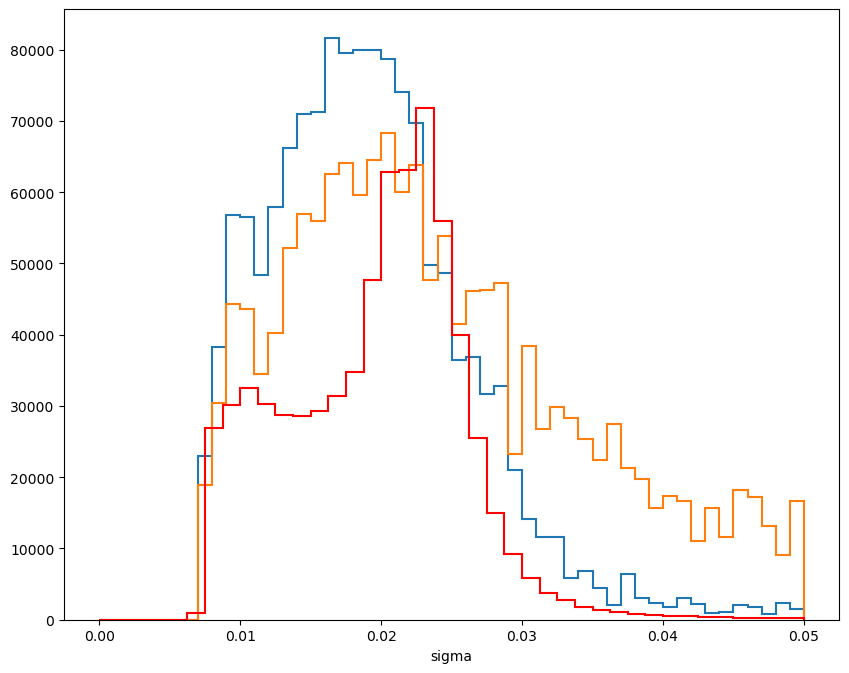

In [ ]:
# lead photon eta
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

var = "sigmaMrv"
ax_name = "sigma"
min_ = 0
max_ = 0.05
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=True, name = ax_name)
LeadPhoton_et_cax = hist.axis.StrCategory(["new", "old"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "sigmaMrv"
full_hist.fill(sigma = qcd_events[var1], weight=qcd_events.weight, c="new")
full_hist.fill(sigma = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False)
h_eta_sig.project(ax_name).plot(ax=ax0, color="red", label="signal x 300")

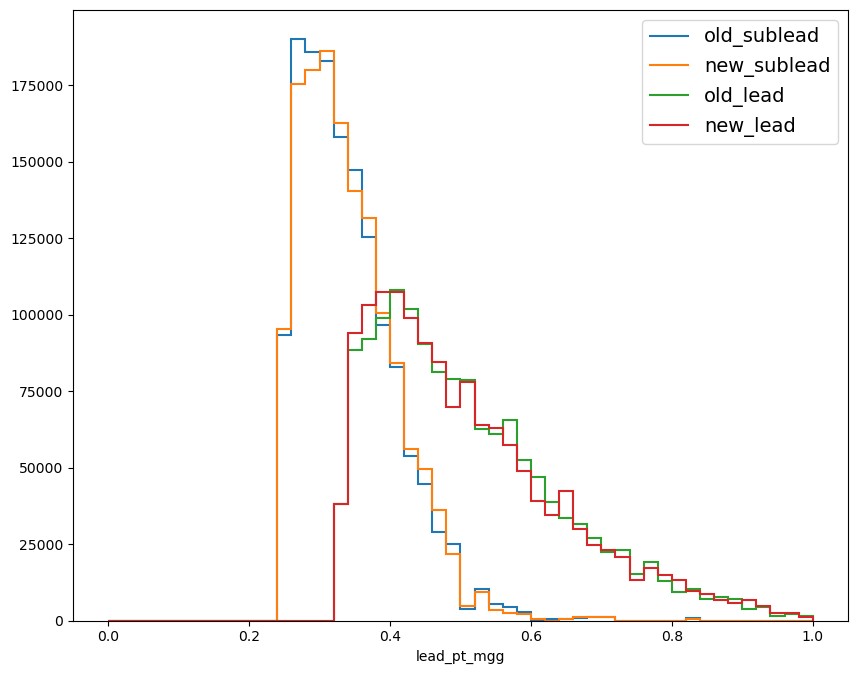

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 0
max_ = 1
nbins = 50

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="lead_pt_mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_pt_mgg"
full_hist.fill(lead_pt_mgg = qcd_events[var1], weight=qcd_events.weight, c="new_lead")
full_hist.fill(lead_pt_mgg = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")
var2 = "SubleadPhoton_pt_mgg"
full_hist.fill(lead_pt_mgg = qcd_events[var2], weight=qcd_events.weight, c="new_sublead")
full_hist.fill(lead_pt_mgg = MC_events[var2][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_sublead")

h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

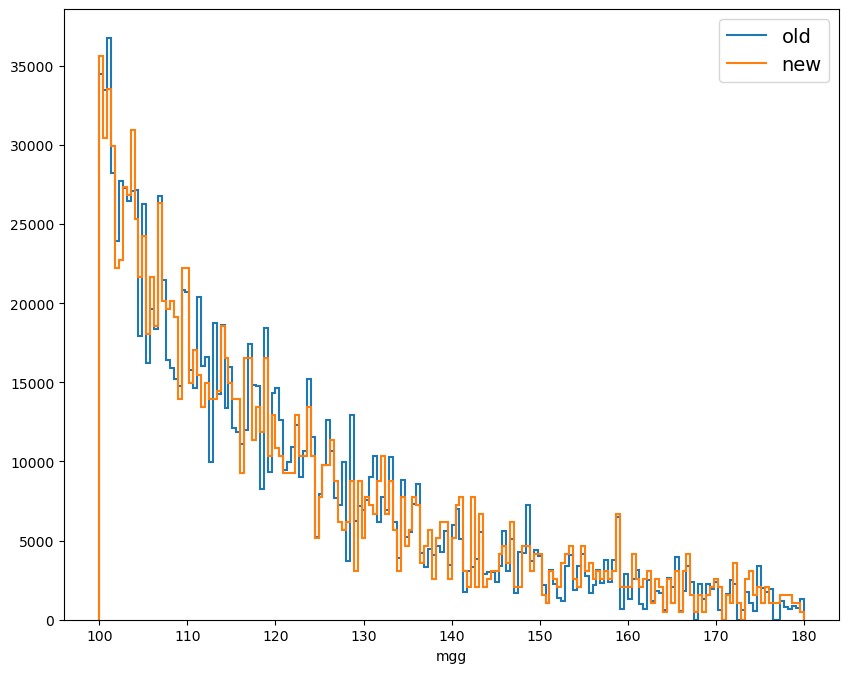

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = 100
max_ = 180
nbins = 180

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="mgg")
LeadPhoton_et_cax = hist.axis.StrCategory(["new", "old"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "CMS_hgg_mass"
full_hist.fill(mgg = qcd_events[var1], weight=qcd_events.weight, c="new")
full_hist.fill(mgg = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old")



h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

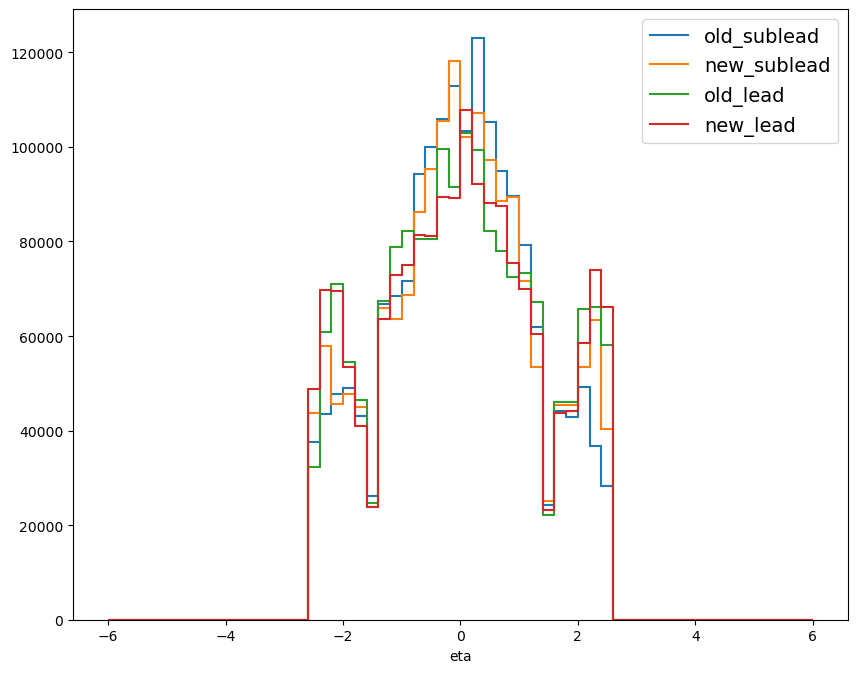

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -6
max_ = 6
nbins = 60

#for field in eta_fields:
#    MC_events[field] = MC_events[field] * np.sign(MC_events.eta)

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_eta"
full_hist.fill(eta = qcd_events[var1], weight=qcd_events.weight, c="new_lead")
full_hist.fill(eta = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")
var2 = "SubleadPhoton_eta"
full_hist.fill(eta = qcd_events[var2], weight=qcd_events.weight, c="new_sublead")
full_hist.fill(eta = MC_events[var2][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_sublead")


h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})

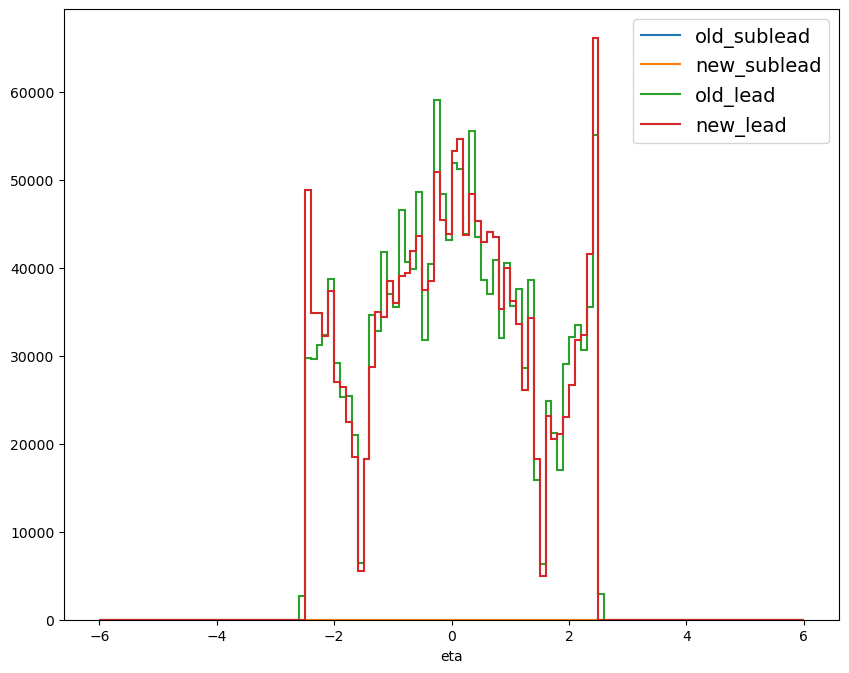

In [ ]:
#bdt_score
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot2grid((5, 3), (0, 0), rowspan=4, colspan=3)

min_ = -6
max_ = 6
nbins = 120

LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="eta")
LeadPhoton_et_cax = hist.axis.StrCategory(["new_lead", "old_lead", "new_sublead", "old_sublead"], name="c")
full_hist = hist.Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

var1 = "LeadPhoton_eta"
full_hist.fill(eta = qcd_events[var1], weight=qcd_events.weight, c="new_lead")
full_hist.fill(eta = MC_events[var1][(MC_events.proc_id == -3)], weight=MC_events.weight[(MC_events.proc_id == -3)], c="old_lead")



h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=ax0, stack=False, )
ax0.legend( prop={'size': 14})